# Malaria Detection using Deep Learning Techniques

## Table of Contents

- [Implementation](#6)

     - [1 Packages and Libraries](#6.1)
     
     - [2 Exploratory Image Analysis](#6.2)
     
         - [2.1 Read and display samples of Whole Slide Images](#6.2.1)
         
             - [2.1.1 Parasitized Samples](#6.2.1.1)
             
             - [2.2.2 Non-Parasitized Samples](#6.2.2.2)
             
         - [2.2  Data Labelling](#6.2.2)
         
         - [2.3 Image Dimensions](#6.2.3)
         
             - [2.3.1 Parasitized Samples](#6.2.3.1)
             
             - [2.3.2 Non-Parasitized Samples](#6.2.3.2)
             
             - [2.3.3 Summary](#6.2.3.3)
             
         - [2.4 Image Resize](#6.2.4)
         
         - [2.5 Image Color Distribution and Histograms](#6.2.5)
         
             - [2.5.1 Parasitized Samples](#6.2.5.1)
             
             - [2.5.2 Non-Parasitized Samples](#6.2.5.2)
             
         - [2.6 Filtering - Noise Removal](#6.2.6)
         
         - [2.7 Data Augmentation](#6.2.7)
         
             - [2.7.1 Horizontal and Vertical Flip Augmentation](#6.2.7.1)
             
             - [2.7.2 Horizontal and Vertical Shift Augmentation](#6.2.7.2)
             
             - [2.7.3 Random Rotation Augmentation](#6.2.7.3)
             
             - [2.7.4 Random Brightness Augmentation](#6.2.7.4)
             
             - [2.7.5 Random Zoom Augmentation](#6.2.7.5)
             
             - [2.7.6 Random Shear Augmentation](#6.2.7.6)
             
             - [2.7.7 Random Channel Shift Augmentation](#6.2.7.7)
             
         - [2.8 Exploratory Image Analysis - Summary](#6.2.8)
         
     - [3 Model Dataset Creation & Train Test Validation Split](#6.3)
     
         - [3.1 Image Rezise - Train Test Validation ImageSets](#6.3.1)
         
         - [3.2 Label Encoding - Train & Validation](#6.3.2)
         
     - [4 Model Training & Validation](#6.4)
     
         - [4.1 Transfer Learning Experiments](#6.4.0)
         
             - [4.1.1 EfficientNet - B0](#6.4.1)
             
             - [4.1.2 EfficientNet - B4](#6.4.2)
             
             - [4.1.3 Inception-v3](#6.4.3)
             
             - [4.1.4 Xception - Extreme Inception](#6.4.4)
             
             - [4.1.5 ResNet50V2](#6.4.5)
             
             - [4.1.6 InceptionResNetV2](#6.4.6)
             
             - [4.1.7 DenseNet121](#6.4.7)
             
         - [4.2 Validation Accuracy & Loss - All Models](#4.2)

         - [4.3 Test Evaluation Metrics - All Models](#4.3)

         - [4.4 AUC ROC & AUC PR Curves - All Models](#4.4)
      
     - [5 Summary](#6.5)

<a name='6'></a>
# Implementation


<a name='6.1'></a>
## 1 Packages and Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import datetime
import glob
import random as rn
import gc
from collections import Counter

import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.offline as py
%config InlineBackend.figure_format = 'retina'
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default='notebook'

from scipy import stats
from statistics import mean 
from statistics import median 
import seaborn as sns
import cv2

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

import tensorflow as tf

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

# from keras import backend as K
# from keras.backend.tensorflow_backend import set_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import get_session

from IPython.display import Markdown

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Import custom packages and utility files

from DataUtility import dataUtils
dUtils = dataUtils()

from DataUtility import IMAGE_AUGMENTATION_TYPE
from DataUtility import RBC_CELL_TYPE

from ModelTrainer import MalariaNet
MalNetTrainer = MalariaNet()

from MalariaModelBuilder import ModelBuilder
MalNetBuilder = ModelBuilder()

from ModelValidator import ValidateModel
MalNetValidator = ValidateModel()

from CustomImageDataGenerator import CustomDataGenerator
MalNetImageGenerator = CustomDataGenerator()

from GradCamUtility import GradCamUtils
MalNetActivations = GradCamUtils()

from Snapshot_Ensembler import SnapshotEnsemble

<a name='6.2'></a>

# 2 Exploratory Image Analysis

In this section, we will explore the various image pre-processing techniques that can be applied to out dataset and make them ready to be fed to the deep learning systems.

<a name='6.2.1'></a>
### 2.1 Read and display samples of Whole Slide Images

<a name='6.2.1.1'></a>
#### 2.1.1 Parasitized Samples

<br>

***Samples of the Red Blood Cells infected by Malarial Parasites...***

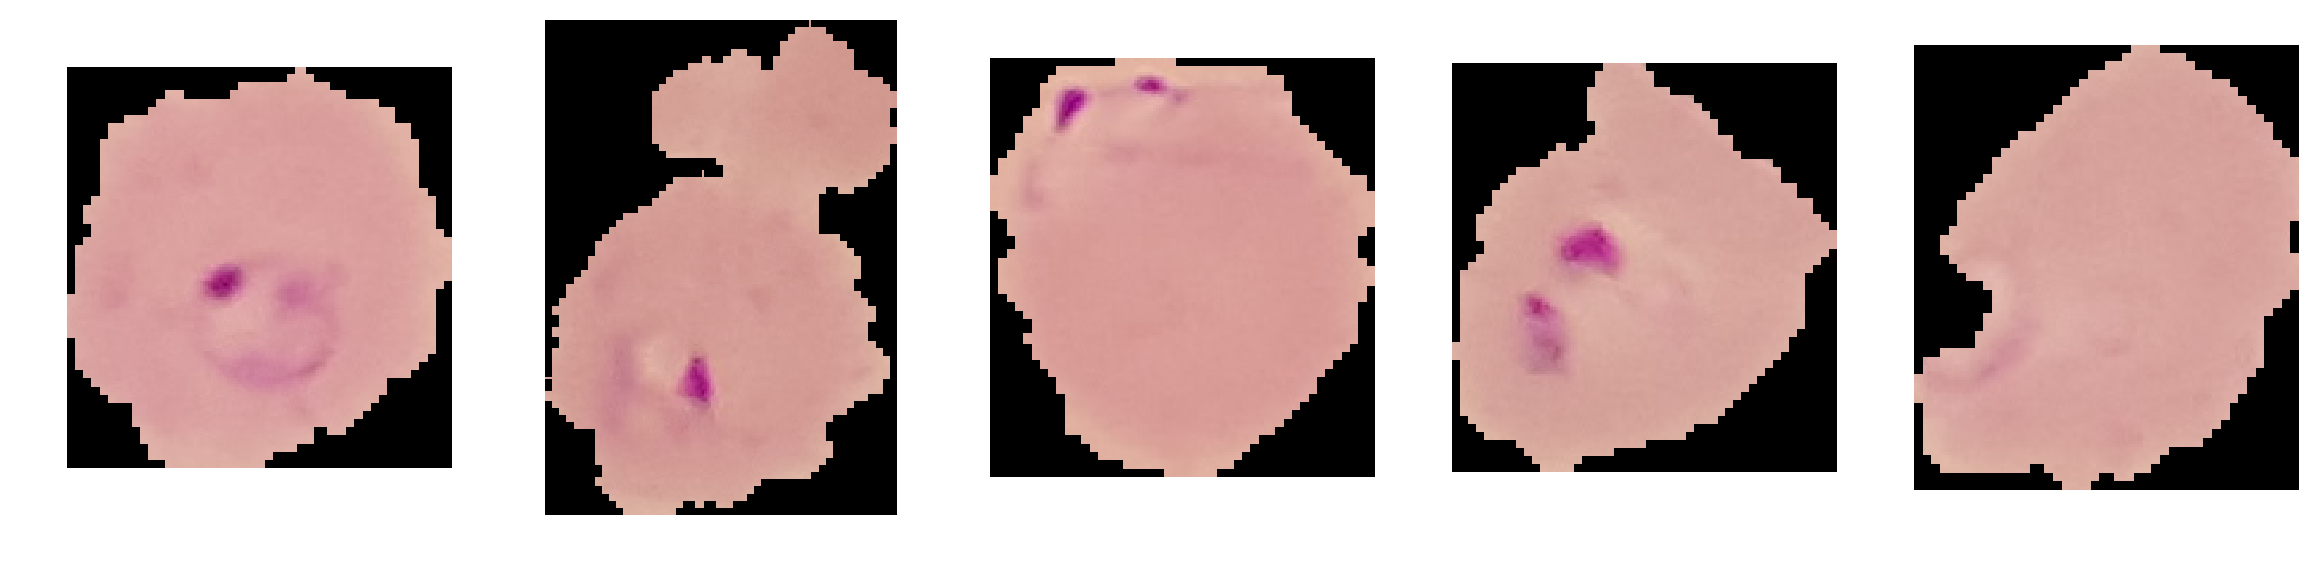

In [3]:
dUtils.PrintMarkdownText('***Samples of the Red Blood Cells infected by Malarial Parasites...***')
dUtils.ReadAndDisplayInputImages(RBC_CELL_TYPE.PARASITIZED.value, 5)

**`As seen in the images above, the parasitized images have a purple colored structure which is the parasite afftected region in the red blood cell. These structures can have a varried shapes and sizes like a ring or oval structure. These ring like structures, their shape, size and the change in color after the staining process helps in determining the parasite species the cell is infected by.`**

<a name='6.2.1.2'></a>
#### 2.1.2 Non-parasitized Samples

<br>

***Samples of the normal Red Blood Cells...***

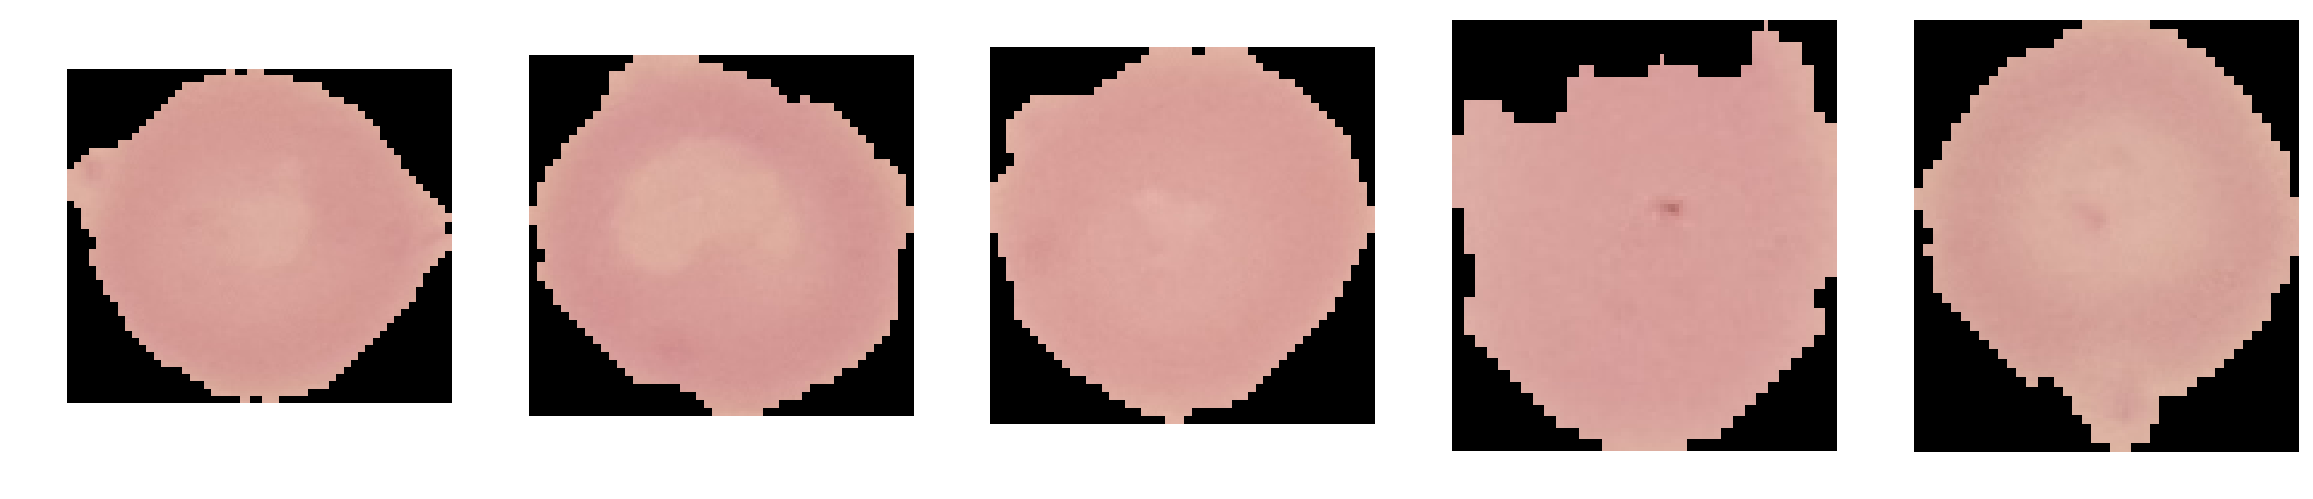

In [4]:
dUtils.PrintMarkdownText('***Samples of the normal Red Blood Cells...***')
dUtils.ReadAndDisplayInputImages(RBC_CELL_TYPE.NONPARASITIZED.value, 5)

<a name='6.2.2'></a>
### 2.2 Data Labelling

The images we have are un-labelled data. Deep learnins systems require proper annotated data to be able to learn the specific representations of each class and perform the job on unseen real time data. So, before proceeding with furtehr analysis we will first assign labels to our data. We have 2 class of images -

1. **Parasitized**

2. **Nonparasitized (or Uninfected)**

Parasitized will be assigned values of 1 and Nonparasitized will be assigned the value 0.

In [3]:
malaria_df = dUtils.GetLabelledMalarialData()

dUtils.PrintMarkdownText('***Labelled malarial images...***')
malaria_df.head()

<br>

***Labelled malarial images...***

filename           label
0  cell_images/Parasitized\C118P79ThinF_IMG_20151...     Parasitized
1  cell_images/Uninfected\C135P96ThinF_IMG_201510...  NonParasitized
2  cell_images/Uninfected\C94P55ThinF_IMG_2015082...  NonParasitized
3  cell_images/Parasitized\C128P89ThinF_IMG_20151...     Parasitized
4  cell_images/Uninfected\C82P43ThinF_IMG_2015081...  NonParasitized

In [6]:
dUtils.PrintMarkdownText('***Annotated malarial dataframe Info...***')
malaria_df.info()

<br>

***Annotated malarial dataframe Info...***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27558 entries, 0 to 27557
Data columns (total 2 columns):
filename    27558 non-null object
label       27558 non-null object
dtypes: object(2)
memory usage: 430.7+ KB


<br>

***Sample Annotated Parasitized & Non-parasitized Images...***

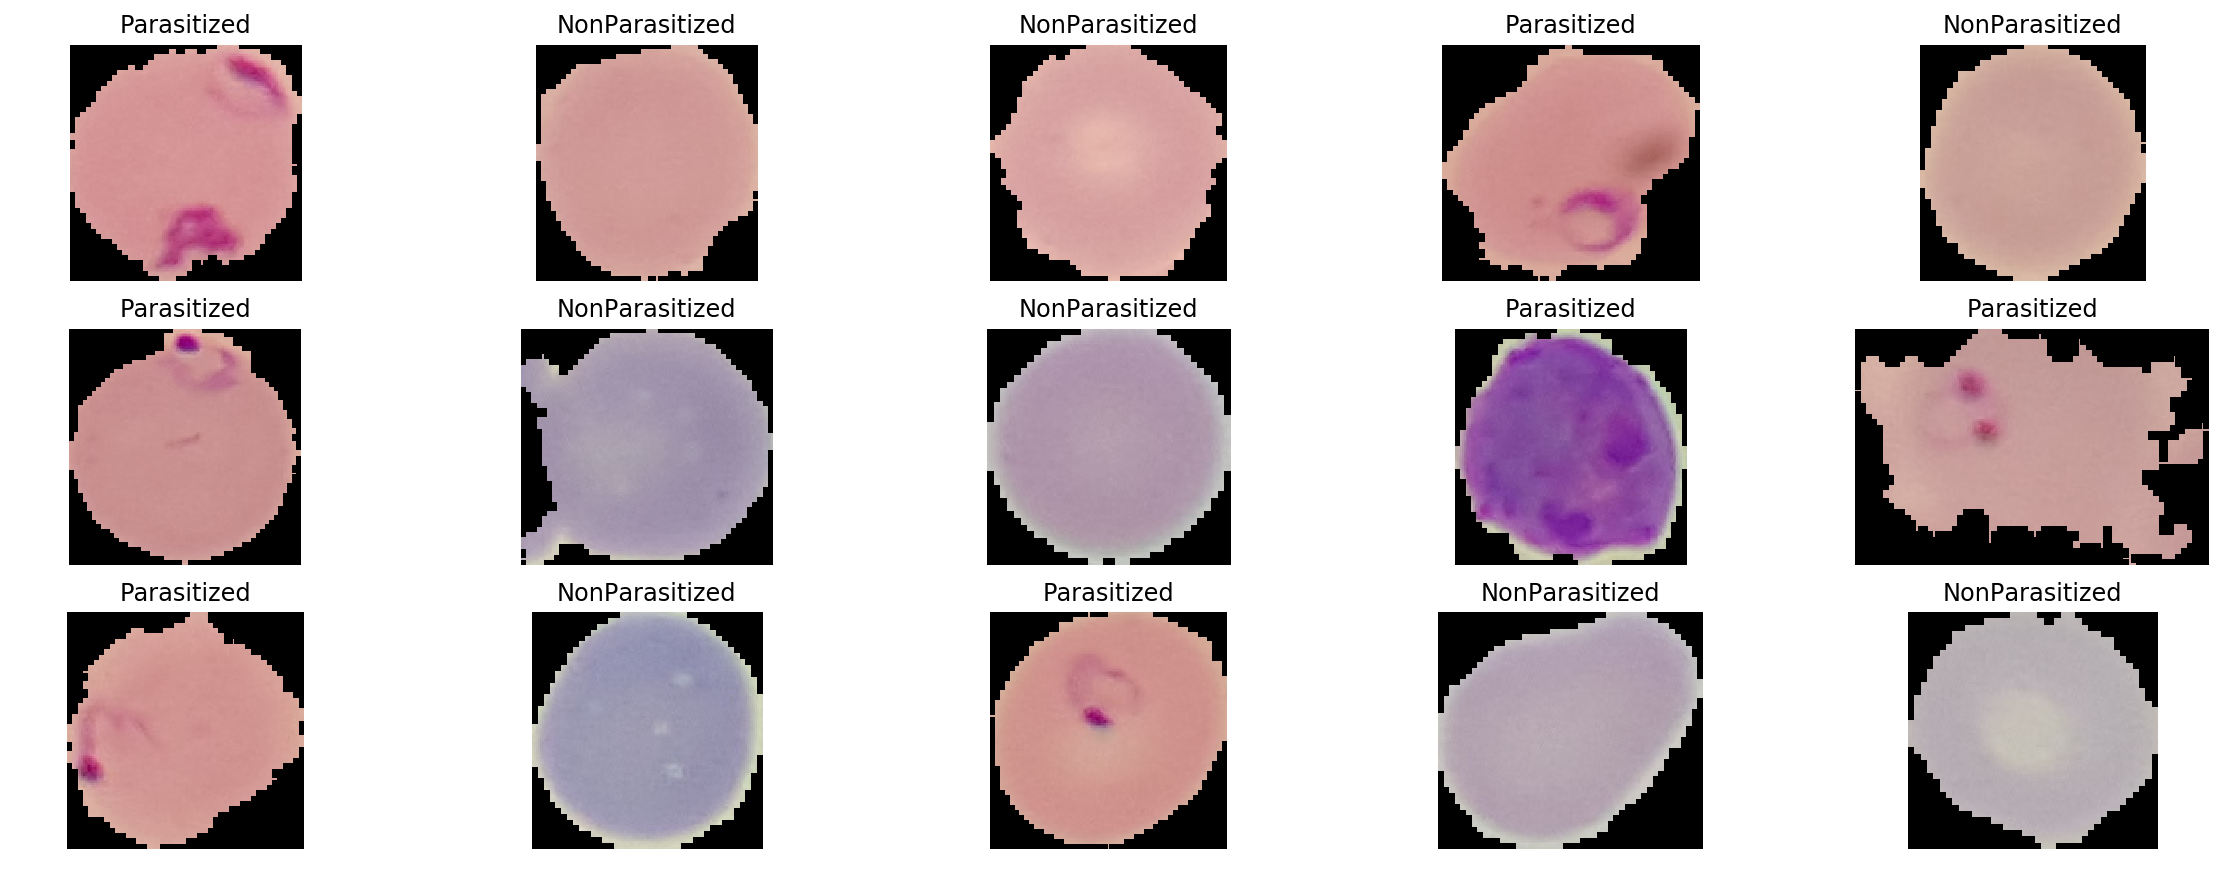

In [7]:
dUtils.PrintMarkdownText('***Sample Annotated Parasitized & Non-parasitized Images...***')
dUtils.DisplayAnnotatedImages(malaria_df, 15)

**Now we have the labels assigned for all the images. As seen the images in both the classes are varrying in dimensions. Lets see the unique sizes of the images we have and the total variations...**
    


<a name='6.2.3'></a>    
### 2.3 Image Dimensions

<a name='6.2.3.1'></a>
#### 2.3.1 Parasitized Samples

In [8]:
# dUtils.PrintMarkdownText('***Shape Distribution for Parasitized Images:***')
# dUtils.ComputeAndPlotImageDimensionalStatistics(RBC_CELL_TYPE.PARASITIZED.value)

<a name='6.2.3.2'></a>
#### 2.3.2 Non-parasitized Samples

In [9]:
# dUtils.PrintMarkdownText('***Shape Distribution for Non-Parasitized Images:***')
# dUtils.ComputeAndPlotImageDimensionalStatistics(RBC_CELL_TYPE.NONPARASITIZED.value)

<a name='6.2.3.3'></a>
***Image Dimensions - SUMMARY :***
    
   So, there are a total of **`1402 unique sized samples`** in the parasitized category & **`1207 unique sized samples`** 
   in the Non-parasitized category. 

   One of the most basic requirement for a smoother model training experience and make the model invariant to varied input
   sizes, resizing is applied such that all the images have a standard size defined for the algorithm. In the context of 
   this study, as seen above the number of uniquely sized images are on the higher side, all the images need to be 
   converted such that they all are of the same dimension. This conversion could be based on the statistical features like 
   the mean or the median size of the images. Lets analyze the statistical distribution of the image size and shape for 
   each category...
   
   Based on the statistical numbers, the size distribution is revolving around the 130 mark for both the parasitized and 
   non-parasitized categories. We will choose **`(135, 135, 3)`** as the common dimension to resize the images.
   
   Below is one example of an image resized to (135, 135, 3).

<a name='6.2.4'></a>

### 2.4 Image Resize - One Sample Image

<br>

***Original vs. Resized Image:***

<Figure size 1440x720 with 0 Axes>

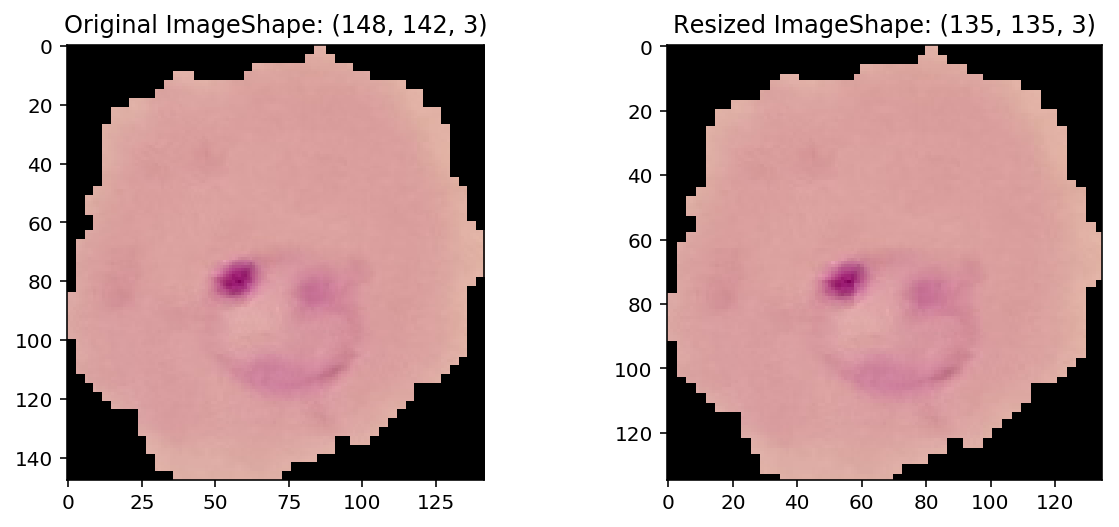

In [10]:
dUtils.PrintMarkdownText('***Original vs. Resized Image:***')

image = dUtils.GetSampleImage(RBC_CELL_TYPE.PARASITIZED.value)
resized_image = cv2.resize(image, (135, 135), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 2)
f.set_figwidth(10)

# Display the Original and the New Resized Image
axes[0].imshow(image)
axes[1].imshow(resized_image)

axes[0].title.set_text('Original Image' + 'Shape: %s' % (image.shape,))
axes[1].title.set_text('Resized Image' + 'Shape: %s' % (resized_image.shape,))

<a name='6.2.5'></a>

### 2.5 Image Color (RGB) Distribution and Histograms

<a name='6.2.5.1'></a>
#### 2.5.1 Parasitized Samples

<br>

***RGB Color Distribution & Histogram in a sample parasitized image***

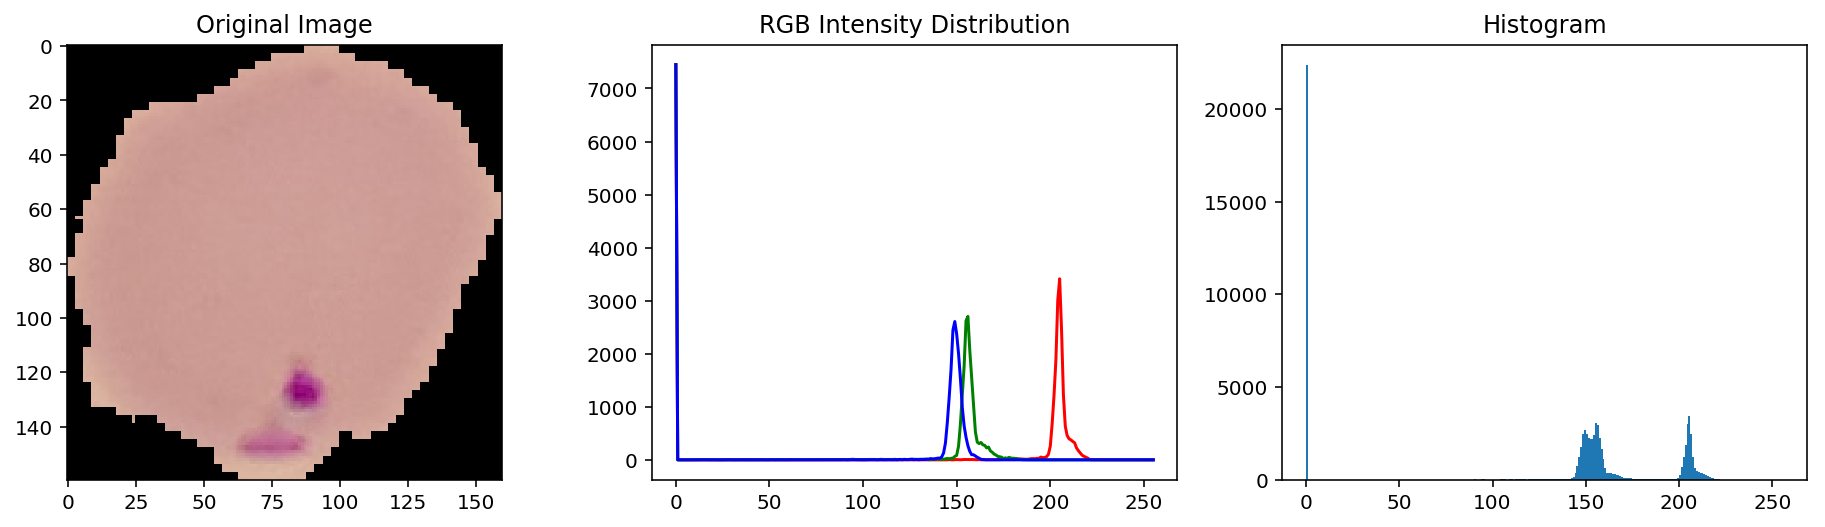

In [11]:
dUtils.PrintMarkdownText("***RGB Color Distribution & Histogram in a sample parasitized image***")
dUtils.PlotImageColorDistribution(RBC_CELL_TYPE.PARASITIZED.value)

<a name='6.2.5.2'></a>
#### 2.5.2 Non-Parasitized Samples

<br>

***RGB Color Distribution & Histogram in a sample non-parasitized image***

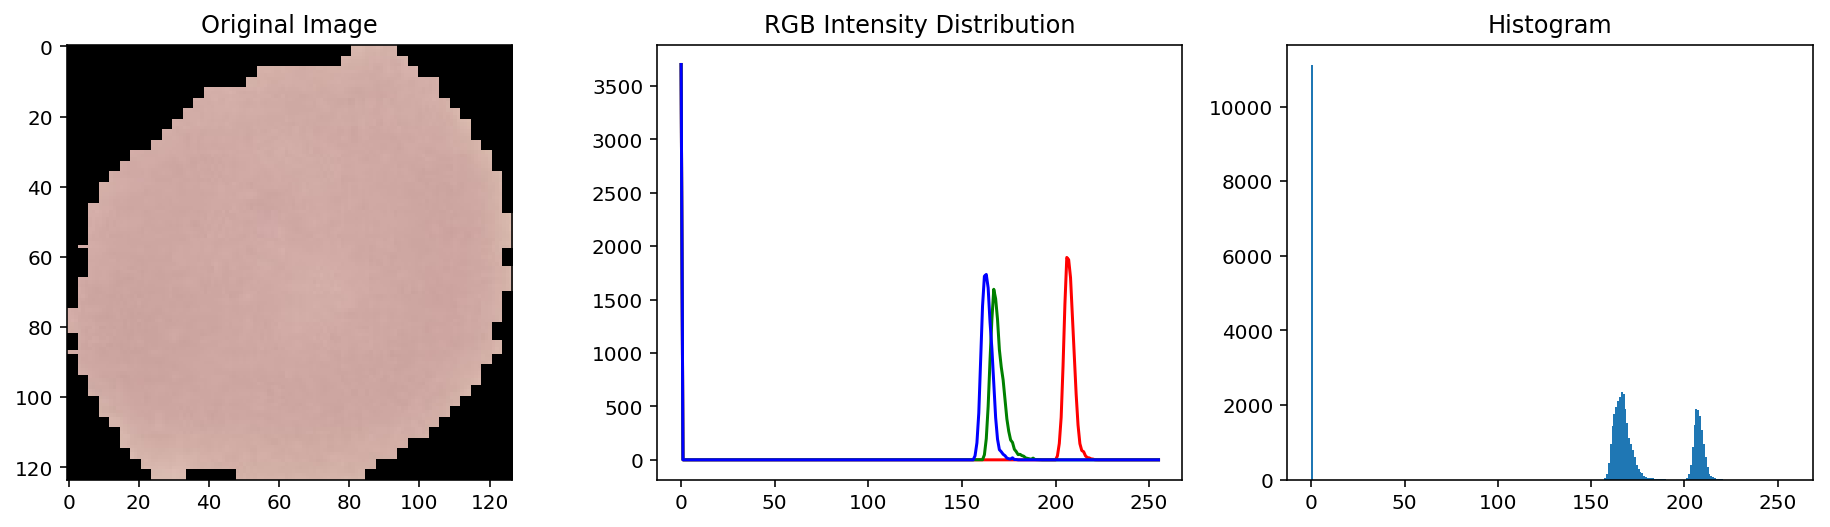

In [12]:
dUtils.PrintMarkdownText("***RGB Color Distribution & Histogram in a sample non-parasitized image***")
dUtils.PlotImageColorDistribution(RBC_CELL_TYPE.NONPARASITIZED.value)

**`As seen for both the parasitized and the non-parasitized cell types, the RGB values are almost on the same intensity levels. Also, the values are around the (140 - 220) range for both the categories.`**

<a name='6.2.6'></a>

### 2.6 Filtering - Noise Removal

***Any random variation that get captured with the image due to uneven lighting conditions, environmental inconsistencies, dust inside the camera can distort and degrade the quality of the image is categorized as noise. Noise is some form is always present in the image (Hambal et al., 2017). The presence of noise in the image could impact a model’s performance. Thus, noise of any kind needs to be removed from the images for an accurate classification.***

We will see the various filetring techniques that are applied for noise removal.

([], <a list of 0 Text yticklabel objects>)

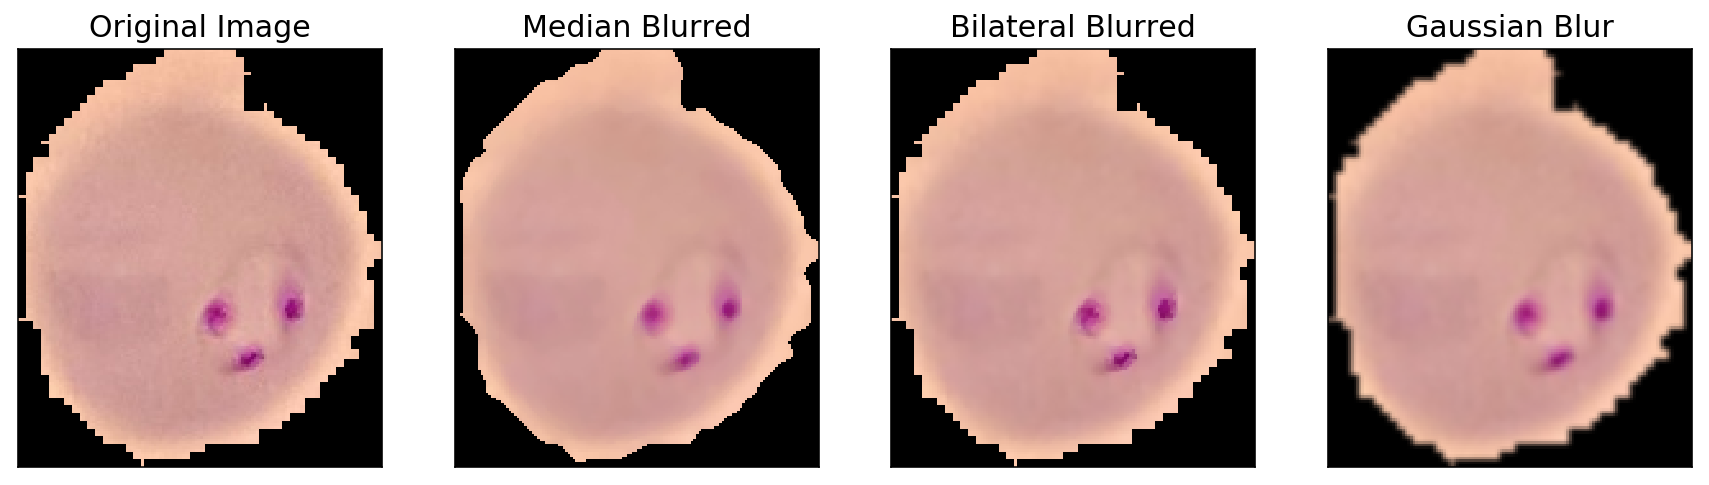

In [13]:
# parasitized = dUtils.GetSampleImage(RBC_CELL_TYPE.PARASITIZED.value)

parasitized = cv2.imread('cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png')
parasitized = cv2.cvtColor(parasitized, cv2.COLOR_BGR2RGB)

# Apply various filters...
median_blurr = cv2.medianBlur(parasitized, 5)
bilateral_blurr = cv2.bilateralFilter(parasitized, 5, 25, 25)
gauss_blurr = cv2.GaussianBlur(parasitized,(5,5),0)

plt.figure(figsize=(15, 20))

plt.subplot(141)
plt.imshow(parasitized)
plt.title('Original Image', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.imshow(median_blurr)
plt.title('Median Blurred', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.imshow(bilateral_blurr)
plt.title('Bilateral Blurred', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.imshow(gauss_blurr)
plt.title('Gaussian Blur', size=15)
plt.xticks([])
plt.yticks([])

**`==> From the above plots, we see that Bilateral filter works well and it preserves the edges too. However, literature survey reveals that the median filtering is the most widely applied technique. So, it remains to be seen which technique will be the better approach for this study.`**

<a name='6.2.7'></a>

### 2.7 Data Augmentation

The term Augmentation refers to making something larger in size. In the context of data, we try to increase the size of the dataset by creating more transformed copies of the original data. This process **`increases the diversity`** in the dataset. Such transformed images help to make the model more robust in handling the real-time images and increase the generalizability of the system. In the context of bio-medical image data, the samples differ from case to case basis. A similar health condition can form a completely different Whole Slide Image. Thus, a deep learning model should be robust enough and be able to generalize on any pattern of the slide image being fed.

In this study, we use the Keras - **`ImageDataGenerator`** module to help with the process of augmentation. The ImageDataGenerator supports various techniques for data augmentation like **`flipping, rotation, cropping, translation, illumination, scaling, adding noise, shift, zooming`**, etc... This enables the model to learn all the variations in these data, increasing the accuracy, robustness and also help to reduce overfitting which often becomes the case with lesser data.

We will see the various augmentation strategies on a sample parasitized red blood cell.

<a name='6.2.7.1'></a>
#### 2.7.1  Horizontal and Vertical Flipping Augmentation

**HORIZONTAL FLIP**

<br>

***Original vs. Augmented Images...***

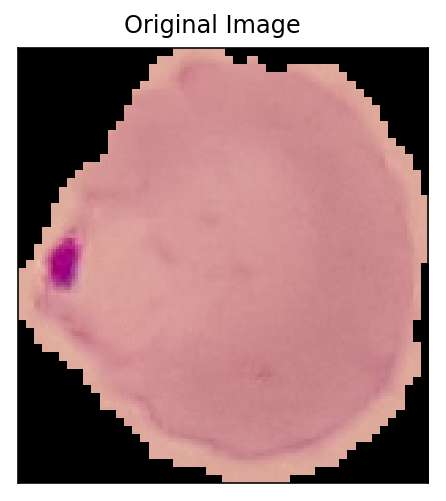

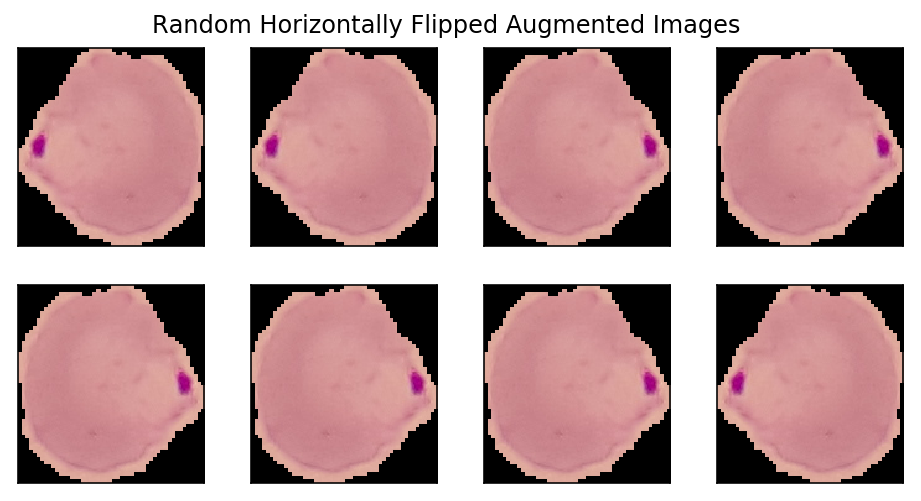

In [14]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.HORIZONTAL_FLIP.value)

**VERTICAL FLIP**

<br>

***Original vs. Augmented Images...***

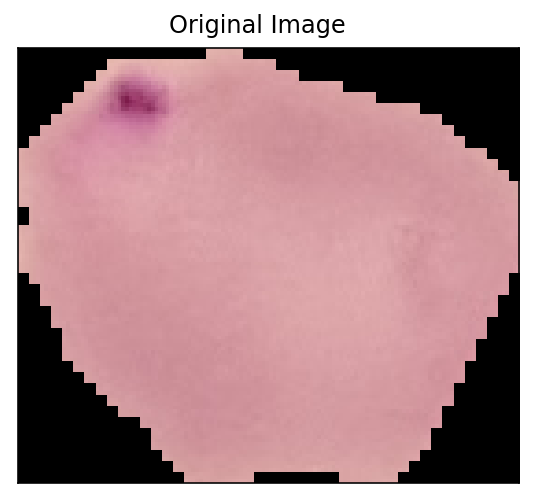

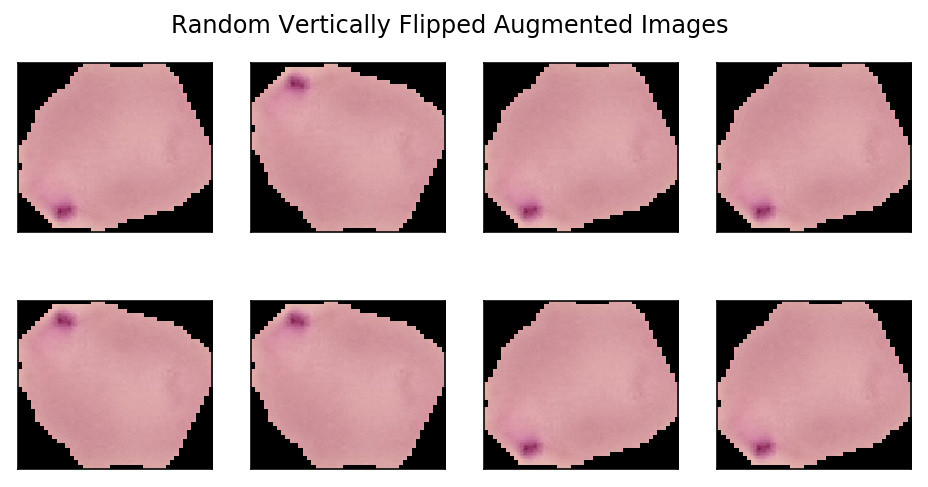

In [15]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.VERTICAL_FLIP.value)

<a name='6.2.7.2'></a>
#### 2.7.2  Horizontal and Vertical Shift Augmentation

**HORIZONTAL SHIFT**

<br>

***Original vs. Augmented Images...***

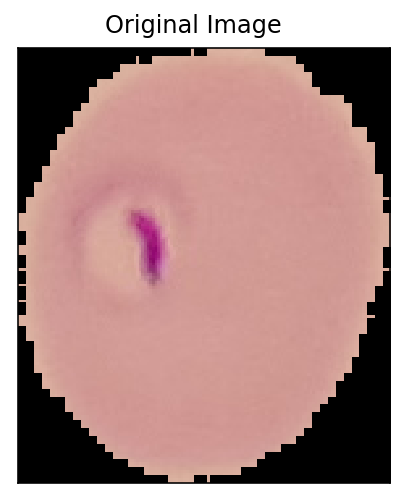

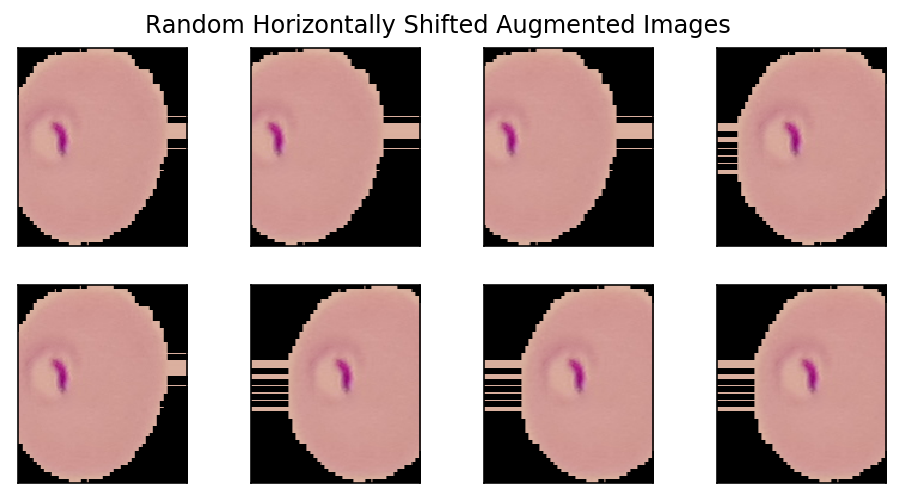

In [16]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.HORIZONTAL_SHIFT.value)

 **VERTICAL SHIFT**

<br>

***Original vs. Augmented Images...***

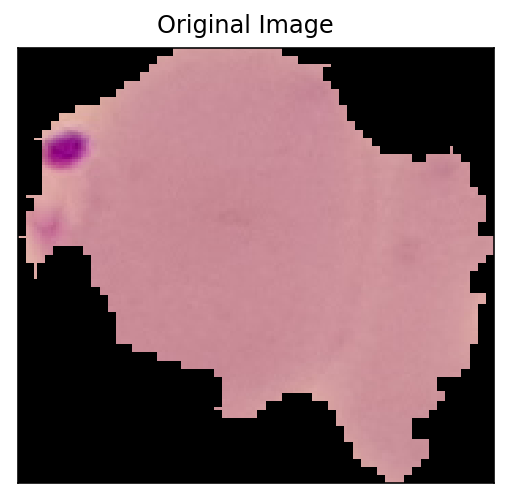

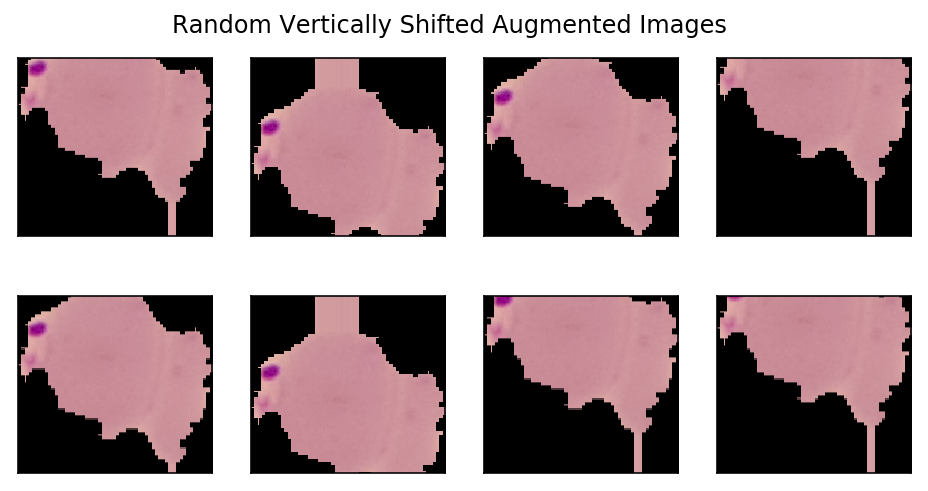

In [17]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.VERTICAL_SHIFT.value)

<a name='6.2.7.3'></a>
#### 2.7.3 Random Rotation Augmentation

<br>

***Original vs. Augmented Images...***

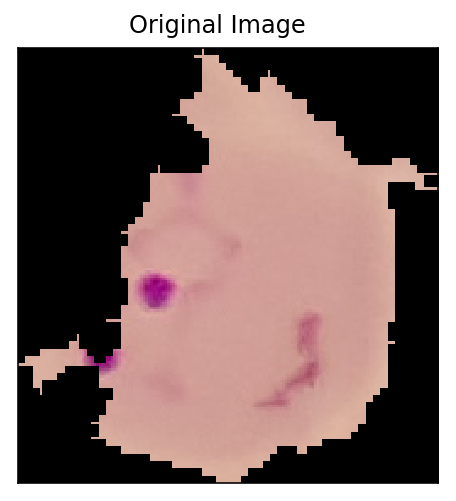

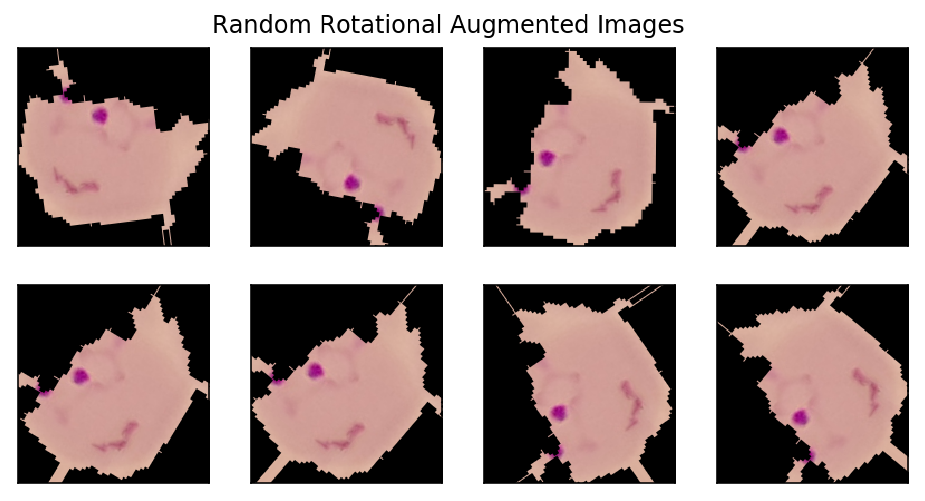

In [18]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_ROTATION.value)

<a name='6.2.7.4'></a>
#### 2.7.4 Random Brightness Augmentation

<br>

***Original vs. Augmented Images...***

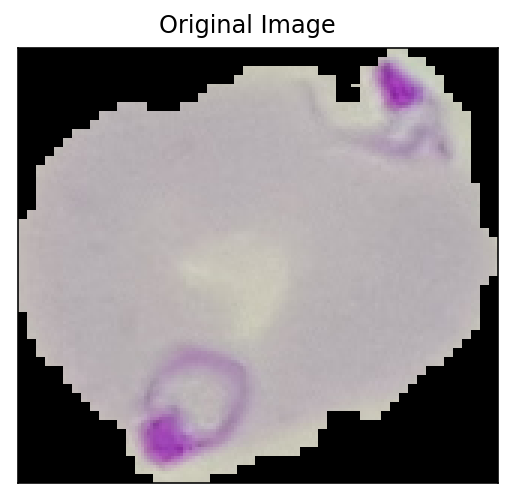

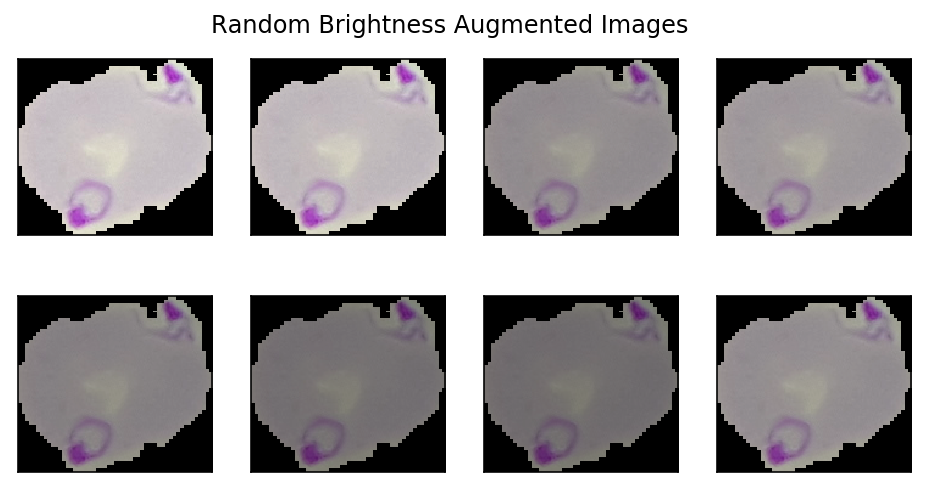

In [19]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_BRIGHTNESS.value)

<a name='6.2.7.5'></a>
#### 2.7.5 Random Zoom Augmentation

<br>

***Original vs. Augmented Images...***

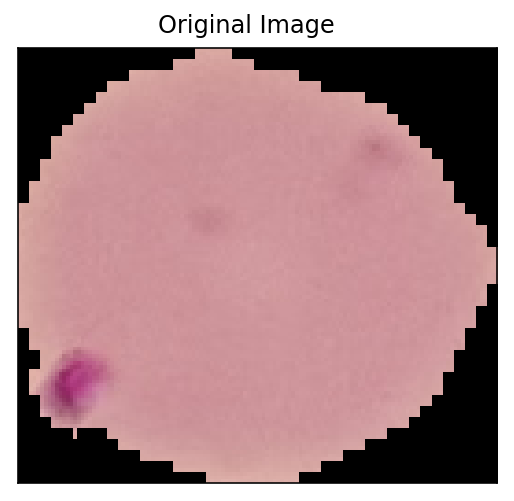

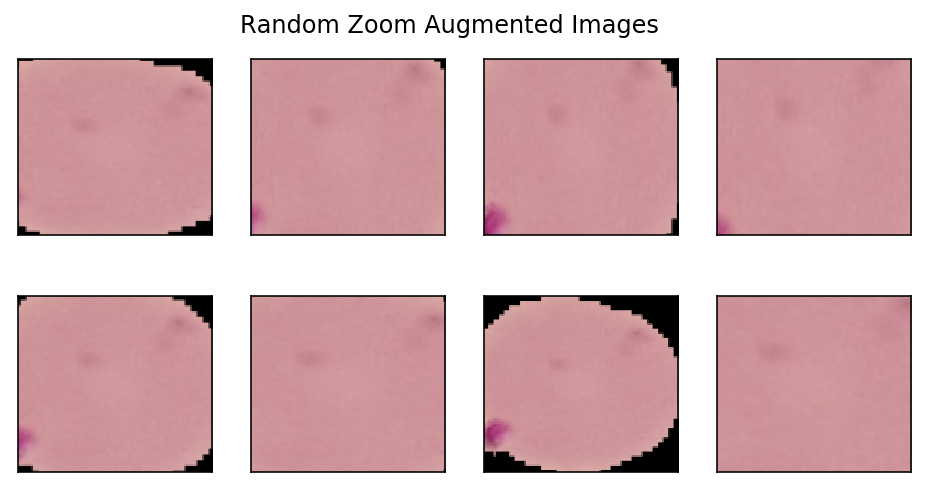

In [20]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_ZOOM.value)

<a name='6.2.7.6'></a>
#### 2.7.6 Random Shear Augmentation

<br>

***Original vs. Augmented Images...***

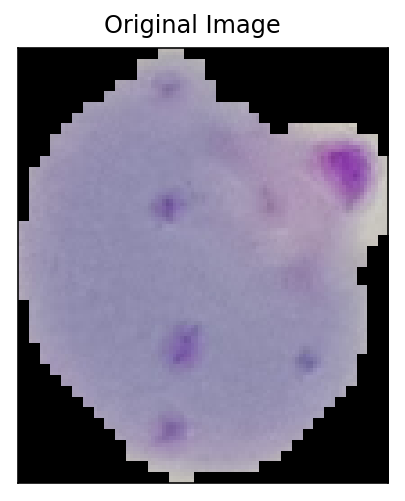

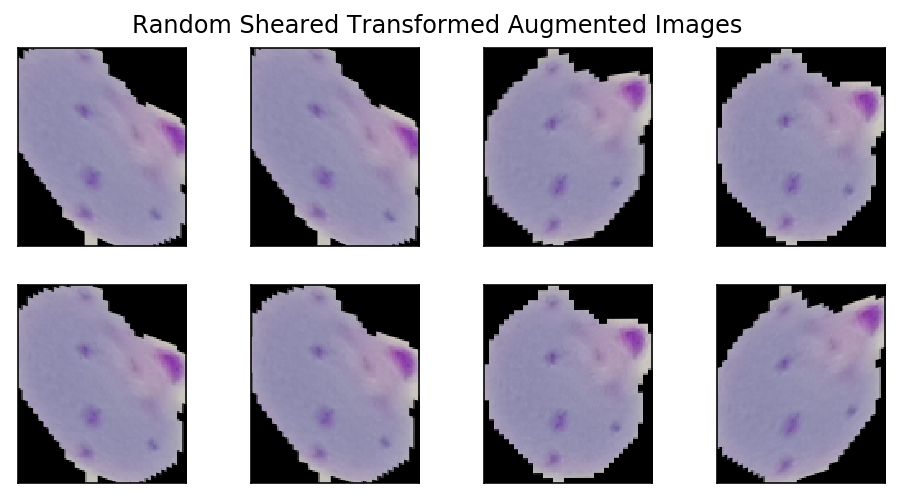

In [21]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_SHEAR.value)

<a name='6.2.7.7'></a>
#### 2.7.7 Random Channel Shift Augmentation

<br>

***Original vs. Augmented Images...***

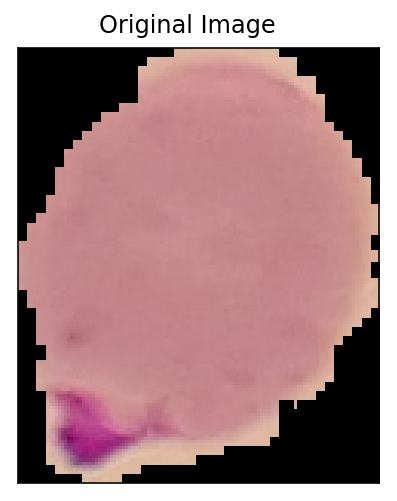

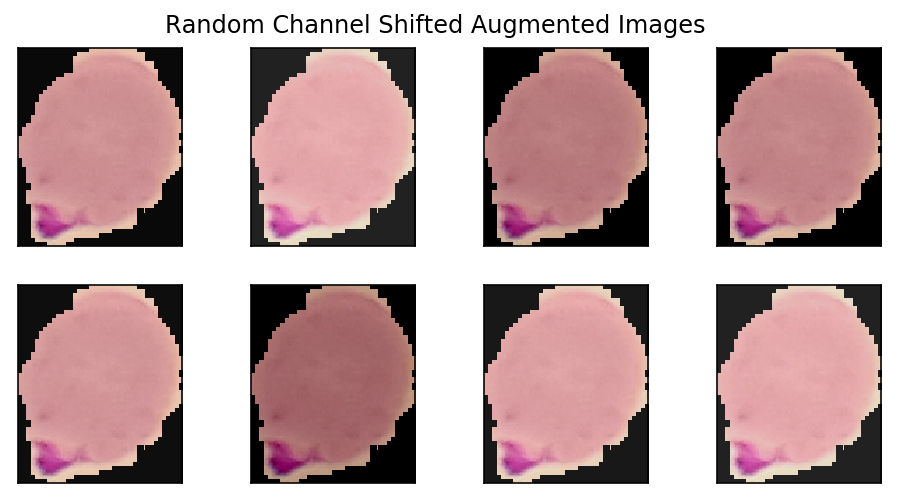

In [22]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.CHANNEL_SHIFT.value)

<a name='6.2.8'></a>
### 2.8 Exploratory Image Analysis - Summary

**With the above exploratory image level analysis, we saw some pre-processing techniques on images that will be the 
pre-requisites for any deep learning system based on images. A summary of the exploratory analysis done so far is 
mentioned below -**

1. **Labelling of Images:** Deep learning systems require annotated data for training. The complete set of images were labelled and divided into 2 classes - **`Parasitized (1)`** & **`Non-parasitized (0)`**.


2. **Image Dimension:** For any algorithm to run and train smoothly the inputs should all be of equal dimensions. Based on the statistical numbers, the size distribution was found to be around the 130 mark for both the parasitized and non-parasitized categories. Thus, **`(135, 135, 3)`** is choosen as the common dimension to resize the images.


3. **Histogram & Color Intensity:** Histograms and RGB color intensity were calculated and plotted on sample images from bith the classes. As seen for both the parasitized and the non-parasitized cell types, the RGB values are almost on the same intensity levels. Also, the values are around the (140 - 220) range for both the categories.


4. **Filtering & Noise Removal:** Median, gaussian and bi-lateral filtering techniques were appplied on sample images. From the corresponding filtered images it can be seen that Bilateral filter works well and it preserves the edges too. However, literature survey reveals that the median filtering is the most widely applied technique. So, it remains to be seen which technique will be the better approach for this study.


5. **Data Augmentation:** Deep learning systems require huge amount of annotated data to be available for training which enables the algorithms learn all the details and variations in the images. Due to a limited dataset available to us, some of the augmentation techniques such as flipping, shifting, rotation, zoom, shear transformation, channel shift, brightness were explored to generate more similar images. The labels of the augmentaed images will be the same as that of the original image.


In adddition to the above pre-processing techniques, all the images will undergo **Normalization** to brings the pixel intensity values to the range of 0-1 and **Standardization** such that the data points such that they follow a ***gaussian distribution*** with mean of zero and standard deviation of one.

<a name='6.3'></a>
# 3 Model Dataset Creation & Train Test Validation Split 

Any Machine Learning/Deep Learning model once trained, needs to be tested on unseen data to check the performance. 

- The data on which the **`model trains`** on is known as the **`Train Dataset`**. 


- The **`unseen data`** on which the trained model is put to **`test for performance`** and get an **`unbiased evaluation`** of the final model is known as the **`Test Dataset`**. 


- There is also an additional dataset created known as the **`Validation Dataset`** which validates the **`performance of the model fit`** during the **`tuning phase of the model hyper-parameters`**.



The percentage of data we would use to split the respective sets would be **`75:15:10`**. As deep learning systems need huge amount of training data, a major chunk - 75% is allocated to the training set. The validation set gets 10% share of the data and while the test set get 15% share.

The full malaria data set (**malaria_df**) is defined in [2.2 Data Labelling](#6.2.2) section. We will use the same dataset to construct our train, test and validation subsets of the data.

In [4]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(malaria_df['filename'].values,
                                                                      malaria_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.10, random_state=42)

In [5]:
dUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Validation Set Length: "  + str(len(validation_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 21081 samples
 -- Validation Set Length: 2343 samples
 -- Test Set Length: 4134 samples


In [25]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

dUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nValidation Data:', Counter(validation_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'NonParasitized': 10548, 'Parasitized': 10533}) 

Validation Data: Counter({'Parasitized': 1173, 'NonParasitized': 1170}) 

Test Data: Counter({'Parasitized': 2073, 'NonParasitized': 2061})


<a name='6.3.1'></a>
### 3.1 Image Rezise - Train Test Validation ImageSets

As discussed in [Section 6.2.3](#6.2.3) for Image Dimensions, statistical summary, the images will be resized to 
**`(135, 135)`**. However, for certain pre-trained models for transfer learning the images will be re-sized to the preffered size depending on the models.

In [5]:
IMG_RESIZE_DIMENSIONS = (135, 135)

In [6]:
train_data = dUtils.ResizeAllImages(train_files, IMG_RESIZE_DIMENSIONS)
validation_data = dUtils.ResizeAllImages(validation_files, IMG_RESIZE_DIMENSIONS)
test_data = dUtils.ResizeAllImages(test_files, IMG_RESIZE_DIMENSIONS)

In [7]:
dUtils.PrintMarkdownText('***Train, Test & Validation Image Dimensional Summary...***')
print('Training Data:', train_data.shape, 
      '\n\nValidation Data:', validation_data.shape, 
      '\n\nTest Data:',test_data.shape)

<br>

***Train, Test & Validation Image Dimensional Summary...***

Training Data: (21081, 100, 100, 3) 

Validation Data: (2343, 100, 100, 3) 

Test Data: (4134, 100, 100, 3)


<a name='6.3.2'></a>
### 3.2 Label Encoding

Encode categorical values **(`'Parasitized' & 'NonParasitized'`)** to convert to the machine readable and interpretable values which would be 0 and 1.

In [7]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_validation = lbl_encoder.transform(validation_labels)
y_test = lbl_encoder.transform(test_labels)

dUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Parasitized', 'NonParasitized', 'Parasitized', 'Parasitized', 'NonParasitized'] 

Encoded Train Labels:     [1 0 1 1 0]


*From the above result -*
__________________________

- 1 denotes **`'Parasitized'`** 
- 0 corresponds to **`'NonParasitized'`**

In [8]:
X_train = train_data / 255.
X_val = validation_data / 255.
X_test = test_data / 255.

<a name='6.4'></a>
## 4 Model Training & Validation

In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 50
INPUT_SHAPE = (135, 135, 3)

<a name='6.4.0'></a>
## 4.1 Transfer Learning

<a name='6.4.1'></a>
### 4.1.1 EfficientNet B0

In [11]:
EfficientNetB0_TL_Model = MalNetBuilder.GetEfficientNetB0Model(bTrainConvolutionBase = True)

16809984/16804768 [==============================] - 2s 0us/step
Model: "Transfer_Learning_EfficientNet_B0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
None


In [12]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [13]:
CallBackList = MalNetTrainer.GetCallBackList("EfficientNetB0_TL_Model")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./EfficientNetB0_TL_Model.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7eff21e9cfd0>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff21e54080>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7eff21e54048>


In [14]:
EfficientNetB0_TL_Model_Train_History = MalNetTrainer.fit_generator(EfficientNetB0_TL_Model,
                                                      train_gen, 
                                                      EPOCHS, 
                                                      val_gen, 
                                                      CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9530
Epoch 00001: val_loss improved from inf to 0.11514, saving model to ./EfficientNetB0_TL_Model.h5
329/329 [==============================] - 146s 443ms/step - loss: 0.1329 - accuracy: 0.9530 - val_loss: 0.1151 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9646
Epoch 00002: val_loss improved from 0.11514 to 0.10706, saving model to ./EfficientNetB0_TL_Model.h5
329/329 [==============================] - 146s 444ms/step - loss: 0.1007 - accuracy: 0.9646 - val_loss: 0.1071 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9682
Epoch 00003: val_loss did not improve from 0.10706
329/329 [==============================] - 144s 439ms/step - loss: 0.0901 - accuracy: 0.9682 - val_loss: 0.1124 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 4/50
329/329 

<br>

***Monitoring Model Train History...***

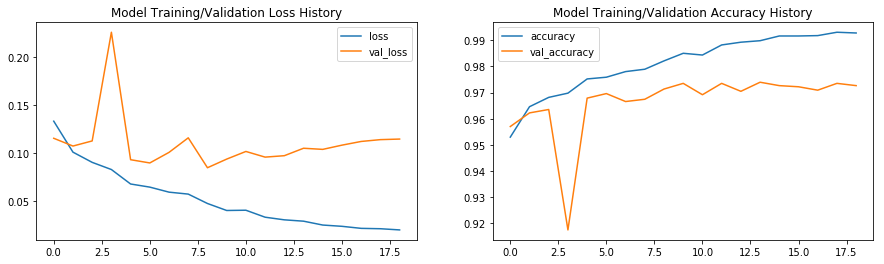

In [15]:
MalNetTrainer.plot_model_history(EfficientNetB0_TL_Model_Train_History)

In [16]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(EfficientNetB0_TL_Model, X_test)

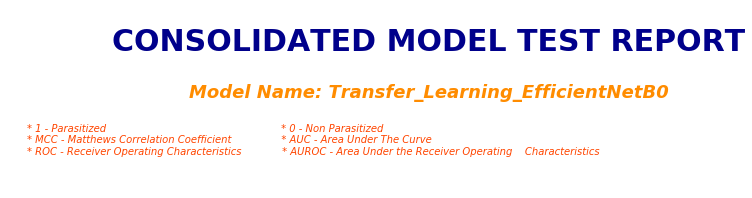

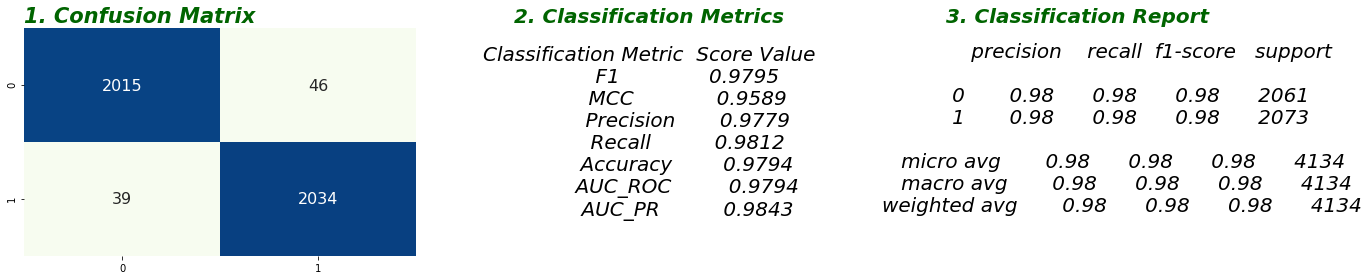

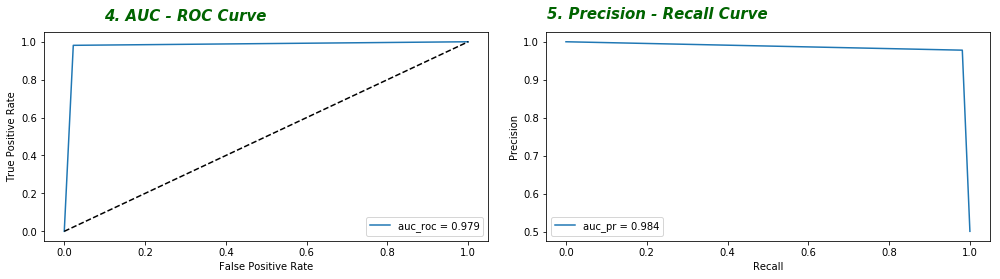

In [17]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, 'Transfer_Learning_EfficientNetB0')

<a name='6.4.2'></a>
### 4.1.2 EfficientNet - B4

In [12]:
EfficientNetB4_TL_Model = MalNetBuilder.GetEfficientNetB4Model(bTrainConvolutionBase=True)

71892992/71892840 [==============================] - 5s 0us/step
Model: "Transfer_Learning_EfficientNetB4_Retrain_Conv_Base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 5, 5, 1792)        17673816  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1792)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1792)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 1793      
Total params: 17,675,609
Trainable params: 17,550,409
Non-trainable params: 125,200
_________________________________________________________________
None


In [13]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [14]:
CallBackList = MalNetTrainer.GetCallBackList("EfficientNetB4_TL_Model")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./EfficientNetB4_TL_Model.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f631cad2048>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f631cad20b8>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7f631cad2080>


In [15]:
EfficientNetB4_TL_Model_Train_History = MalNetTrainer.fit_generator(EfficientNetB4_TL_Model,
                                                                    train_gen, 
                                                                    EPOCHS, 
                                                                    val_gen, 
                                                                    CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9521
Epoch 00001: val_loss improved from inf to 0.15851, saving model to ./EfficientNetB4_TL_Model.h5
329/329 [==============================] - 377s 1s/step - loss: 0.1446 - accuracy: 0.9521 - val_loss: 0.1585 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9655
Epoch 00002: val_loss improved from 0.15851 to 0.11876, saving model to ./EfficientNetB4_TL_Model.h5
329/329 [==============================] - 377s 1s/step - loss: 0.1002 - accuracy: 0.9655 - val_loss: 0.1188 - val_accuracy: 0.9666 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9690
Epoch 00003: val_loss improved from 0.11876 to 0.10074, saving model to ./EfficientNetB4_TL_Model.h5
329/329 [==============================] - 375s 1s/step - loss: 0.0905 - accuracy: 0.9690 - val_loss: 0.1007 - val_accuracy

<br>

***Monitoring Model Train History...***

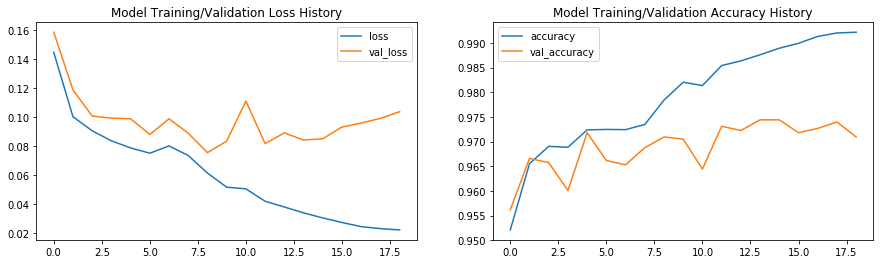

In [16]:
MalNetTrainer.plot_model_history(EfficientNetB4_TL_Model_Train_History)

In [17]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(EfficientNetB4_TL_Model, X_test)

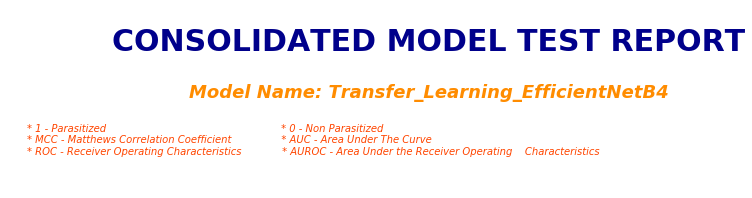

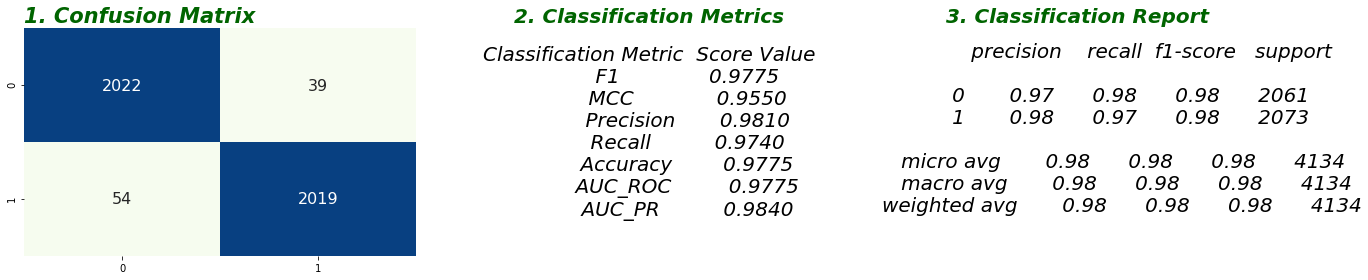

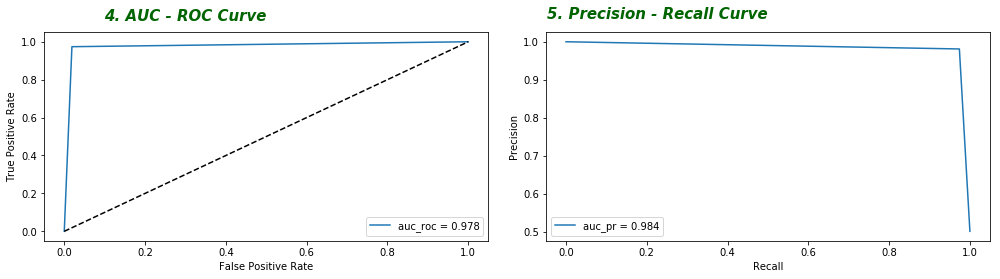

In [18]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, 'Transfer_Learning_EfficientNetB4')

<a name='6.4.3'></a>
### 4.1.3 Inception-v3

In [45]:
Inception_v3_TL_Model_Trainable_True = MalNetBuilder.GetInceptionv3Model(bTrainConvolutionBase = True)

Model: "Transfer_Learning_Inception_v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________
None


In [47]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [48]:
CallBackList = MalNetTrainer.GetCallBackList("Inception_v3_TL_Model_Trainable_True")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./Inception_v3_TL_Model_Trainable_True.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7fc900ecf4a8>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fc900ecf518>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7fc900ecf4e0>


In [49]:
Inception_v3_TL_Model_Trainable_True_Train_History = MalNetTrainer.fit_generator(Inception_v3_TL_Model_Trainable_True,
                                                                                 train_gen, 
                                                                                 EPOCHS, 
                                                                                 val_gen, 
                                                                                 CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9378
Epoch 00001: val_loss improved from inf to 0.22128, saving model to ./Inception_v3_TL_Model_Trainable_True.h5
329/329 [==============================] - 124s 378ms/step - loss: 0.1800 - accuracy: 0.9378 - val_loss: 0.2213 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9574
Epoch 00002: val_loss did not improve from 0.22128
329/329 [==============================] - 122s 372ms/step - loss: 0.1279 - accuracy: 0.9574 - val_loss: 0.2334 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9613
Epoch 00003: val_loss improved from 0.22128 to 0.13904, saving model to ./Inception_v3_TL_Model_Trainable_True.h5
329/329 [==============================] - 125s 380ms/step - loss: 0.1167 - accuracy: 0.9613 - val_loss: 0.1390 - val_accuracy: 0.9579 - lr: 

<br>

***Monitoring Model Train History...***

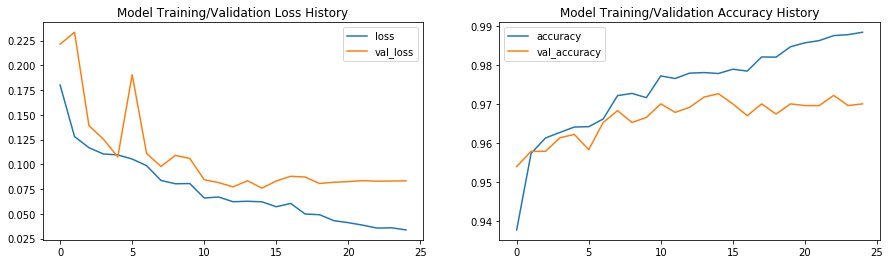

In [50]:
MalNetTrainer.plot_model_history(Inception_v3_TL_Model_Trainable_True_Train_History)

In [51]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(Inception_v3_TL_Model_Trainable_True, X_test)

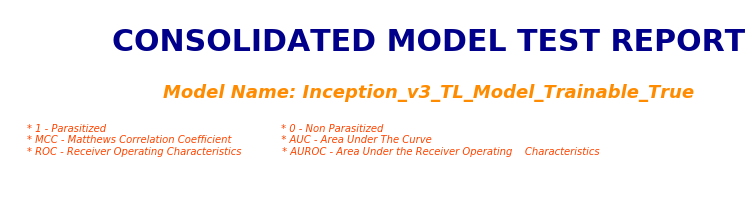

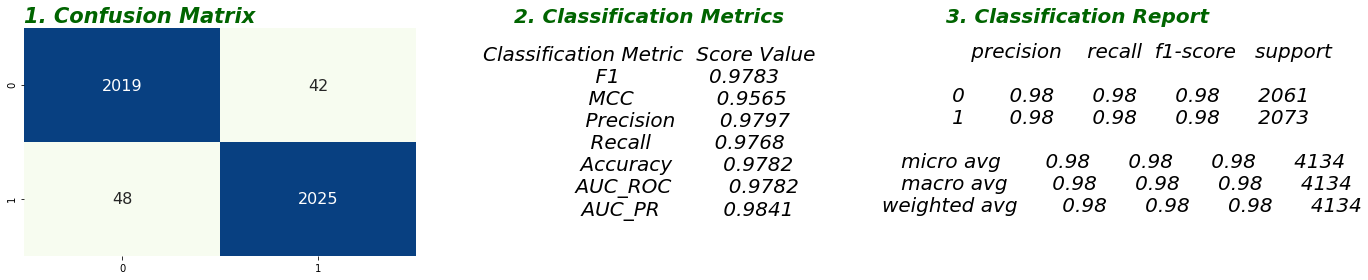

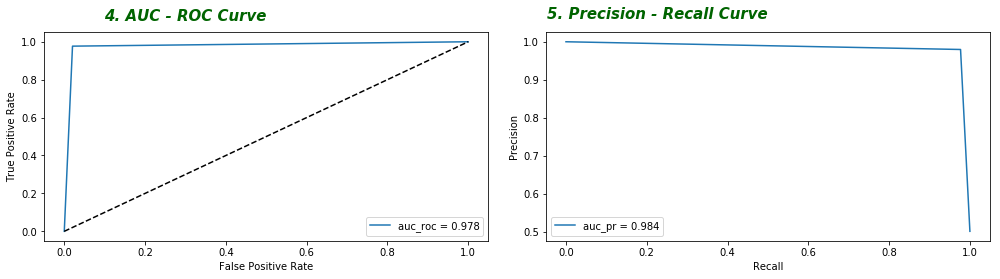

In [52]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "Inception_v3_TL_Model_Trainable_True")

<a name='6.4.4'></a>
## 4.1.4 Xception - Extreme Inception 

In [12]:
Xception_TL_Model = MalNetBuilder.GetXceptionModel(bTrainConvolutionBase=True)

83689472/83683744 [==============================] - 2s 0us/step
Model: "Transfer_Learning_Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________
None


In [13]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [14]:
CallBackList = MalNetTrainer.GetCallBackList("Xception_TL_Model")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./Xception_TL_Model.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f28b81d2eb8>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f28b81d2f28>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7f28b81d2ef0>


In [15]:
Xception_TL_Model_Train_History = MalNetTrainer.fit_generator(Xception_TL_Model,
                                                                 train_gen, 
                                                                 EPOCHS, 
                                                                 val_gen, 
                                                                 CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9527
Epoch 00001: val_loss improved from inf to 0.15167, saving model to ./Xception_TL_Model.h5
329/329 [==============================] - 346s 1s/step - loss: 0.1380 - accuracy: 0.9527 - val_loss: 0.1517 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9651
Epoch 00002: val_loss improved from 0.15167 to 0.12514, saving model to ./Xception_TL_Model.h5
329/329 [==============================] - 347s 1s/step - loss: 0.1037 - accuracy: 0.9651 - val_loss: 0.1251 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9670
Epoch 00003: val_loss improved from 0.12514 to 0.10661, saving model to ./Xception_TL_Model.h5
329/329 [==============================] - 345s 1s/step - loss: 0.0945 - accuracy: 0.9670 - val_loss: 0.1066 - val_accuracy: 0.9644 - lr: 0.0

<br>

***Monitoring Model Train History...***

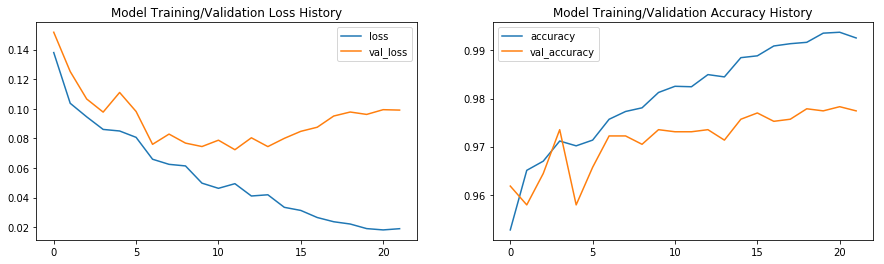

In [16]:
MalNetTrainer.plot_model_history(Xception_TL_Model_Train_History)

In [17]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(Xception_TL_Model, X_test)

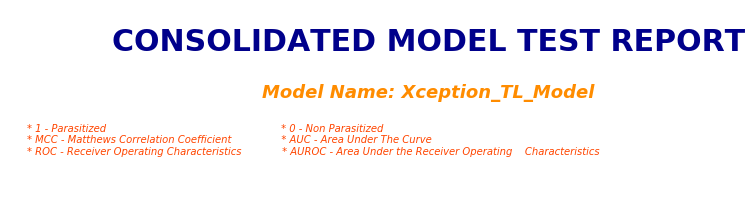

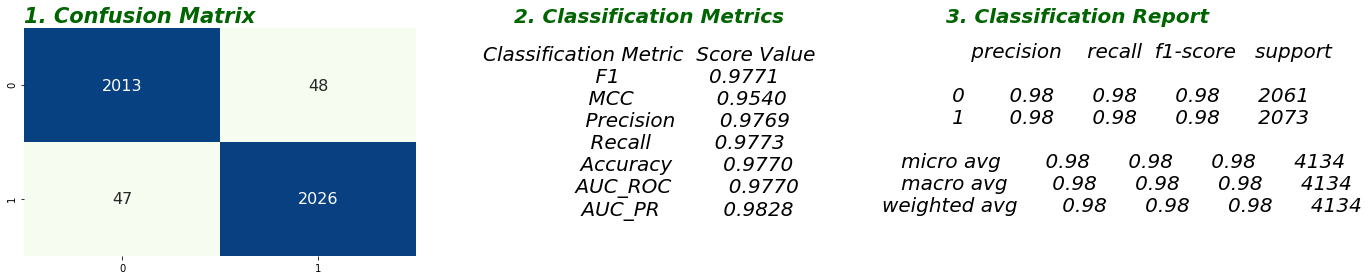

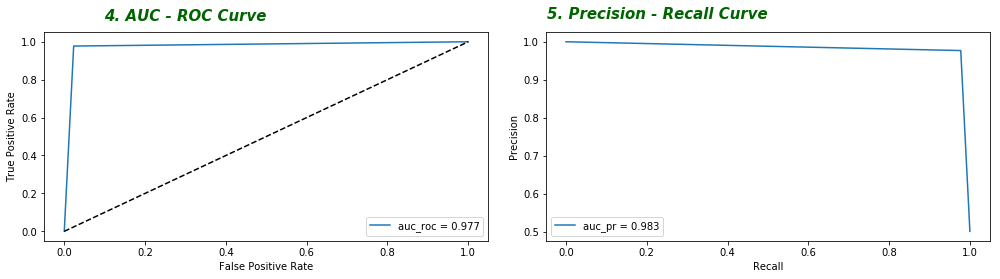

In [18]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "Xception_TL_Model")

<a name='6.4.5'></a>
### 4.1.5 ResNet50V2

In [11]:
ResNet50V2_TL_Model = MalNetBuilder.GetResNet50V2Model(bTrainConvolutionBase=True)

94674944/94668760 [==============================] - 3s 0us/step
Model: "Transfer_Learning_ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________
None


In [12]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [13]:
CallBackList = MalNetTrainer.GetCallBackList("ResNet50V2_TL_Model")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./ResNet50V2_TL_Model.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7fbf59e0d0b8>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fbf59e0d128>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7fbf59e0d0f0>


In [14]:
ResNet50V2_TL_Model_Train_History = MalNetTrainer.fit_generator(ResNet50V2_TL_Model,
                                                                train_gen, 
                                                                EPOCHS, 
                                                                val_gen, 
                                                                CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9450
Epoch 00001: val_loss improved from inf to 0.74132, saving model to ./ResNet50V2_TL_Model.h5
329/329 [==============================] - 191s 582ms/step - loss: 0.1676 - accuracy: 0.9450 - val_loss: 0.7413 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9556
Epoch 00002: val_loss did not improve from 0.74132
329/329 [==============================] - 190s 578ms/step - loss: 0.1318 - accuracy: 0.9556 - val_loss: 1.3110 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9581
Epoch 00003: val_loss improved from 0.74132 to 0.15256, saving model to ./ResNet50V2_TL_Model.h5
329/329 [==============================] - 193s 586ms/step - loss: 0.1248 - accuracy: 0.9581 - val_loss: 0.1526 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 4/50
329/329 [=======

<br>

***Monitoring Model Train History...***

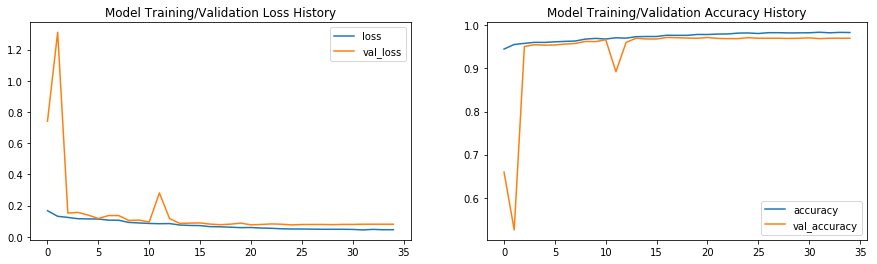

In [15]:
MalNetTrainer.plot_model_history(ResNet50V2_TL_Model_Train_History)

In [16]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(ResNet50V2_TL_Model, X_test)

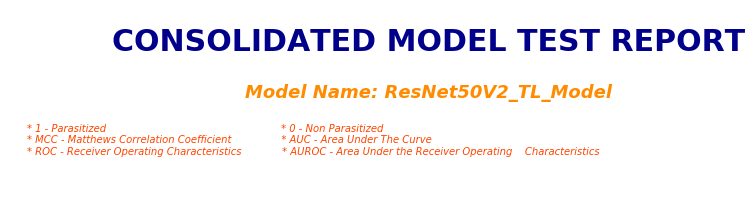

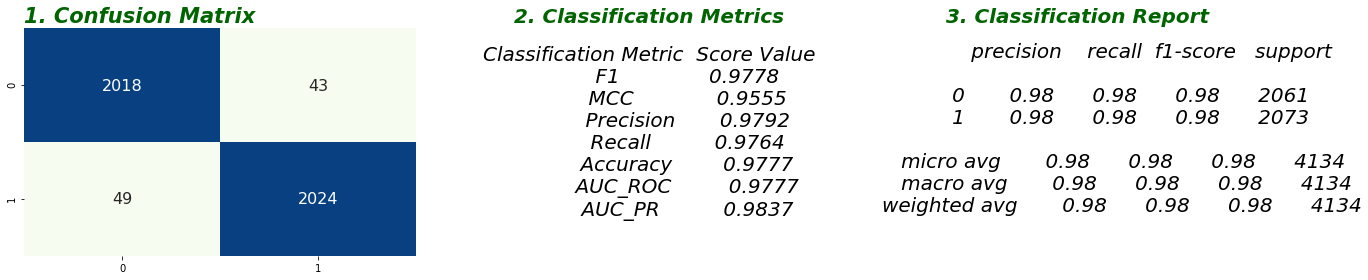

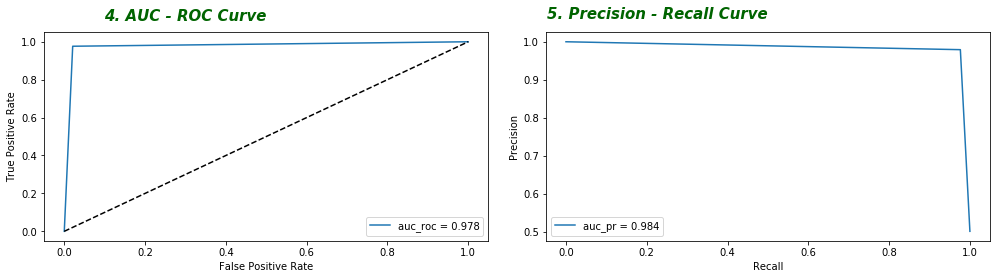

In [17]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "ResNet50V2_TL_Model")

<a name='6.4.6'></a>
### 4.1.6 InceptionResNetV2

In [9]:
InceptionResNetV2_TL_Model = MalNetBuilder.GetInceptionResNetV2Model(bTrainConvolutionBase=True)

219062272/219055592 [==============================] - 4s 0us/step
Model: "Transfer_Learning_InceptionResNetV2_Retrain_Conv_Base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1536)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1536)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________
None


In [10]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [11]:
CallBackList = MalNetTrainer.GetCallBackList("InceptionResNetV2_TL_Model")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./InceptionResNetV2_TL_Model.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7fb4809751d0>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fb480975240>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7fb480975208>


In [12]:
InceptionResNetV2_TL_Model_Train_History = MalNetTrainer.fit_generator(InceptionResNetV2_TL_Model,
                                                                       train_gen, 
                                                                       EPOCHS, 
                                                                       val_gen, 
                                                                       CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9325
Epoch 00001: val_loss improved from inf to 0.14848, saving model to ./InceptionResNetV2_TL_Model.h5
329/329 [==============================] - 296s 899ms/step - loss: 0.1920 - accuracy: 0.9325 - val_loss: 0.1485 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9584
Epoch 00002: val_loss did not improve from 0.14848
329/329 [==============================] - 289s 878ms/step - loss: 0.1214 - accuracy: 0.9584 - val_loss: 0.2010 - val_accuracy: 0.9301 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9643
Epoch 00003: val_loss improved from 0.14848 to 0.09217, saving model to ./InceptionResNetV2_TL_Model.h5
329/329 [==============================] - 295s 898ms/step - loss: 0.1068 - accuracy: 0.9643 - val_loss: 0.0922 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/50
32

<br>

***Monitoring Model Train History...***

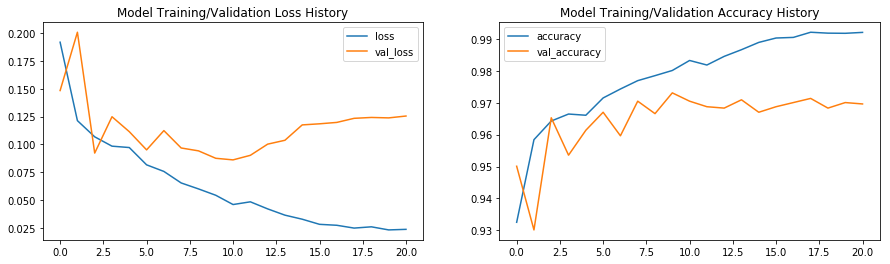

In [13]:
MalNetTrainer.plot_model_history(InceptionResNetV2_TL_Model_Train_History)

In [14]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(InceptionResNetV2_TL_Model, X_test)

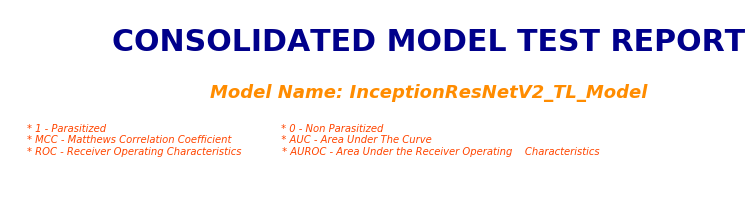

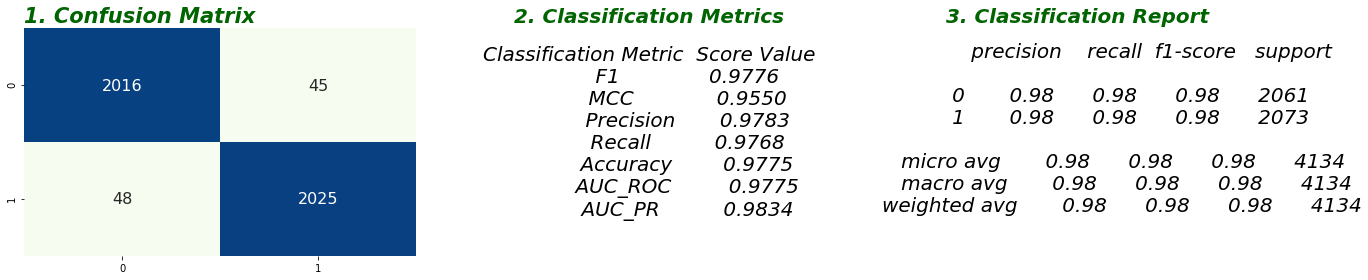

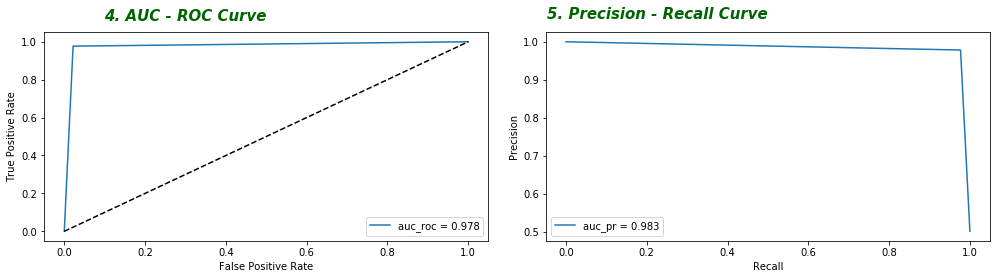

In [15]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "InceptionResNetV2_TL_Model")

<a name='6.4.7'></a>
### 4.1.7 DenseNet121

In [11]:
DenseNet121_TL_Model = MalNetBuilder.GetDenseNet121Model(bTrainConvolutionBase=True)

29089792/29084464 [==============================] - 1s 0us/step
Model: "Transfer_Learning_DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1024)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1024)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
None


In [12]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [13]:
CallBackList = MalNetTrainer.GetCallBackList("DenseNet121_TL_Model")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./DenseNet121_TL_Model.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7eff20573ba8>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff20573c18>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7eff20573be0>


In [14]:
DenseNet121_TL_Model_Train_History = MalNetTrainer.fit_generator(DenseNet121_TL_Model,
                                                                 train_gen, 
                                                                 EPOCHS, 
                                                                 val_gen, 
                                                                 CallBackList)

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9477
Epoch 00001: val_loss improved from inf to 0.23819, saving model to ./DenseNet121_TL_Model.h5
329/329 [==============================] - 196s 595ms/step - loss: 0.1592 - accuracy: 0.9477 - val_loss: 0.2382 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9580
Epoch 00002: val_loss improved from 0.23819 to 0.13176, saving model to ./DenseNet121_TL_Model.h5
329/329 [==============================] - 195s 594ms/step - loss: 0.1223 - accuracy: 0.9580 - val_loss: 0.1318 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9633
Epoch 00003: val_loss did not improve from 0.13176
329/329 [==============================] - 194s 588ms/step - loss: 0.1094 - accuracy: 0.9633 - val_loss: 0.1367 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 4/50
329/329 [=====

<br>

***Monitoring Model Train History...***

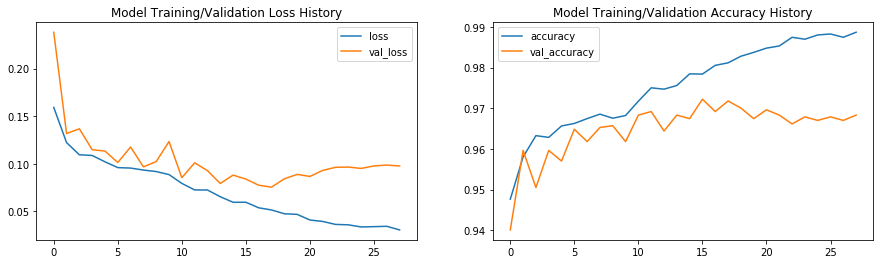

In [15]:
MalNetTrainer.plot_model_history(DenseNet121_TL_Model_Train_History)

In [16]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(DenseNet121_TL_Model, X_test)

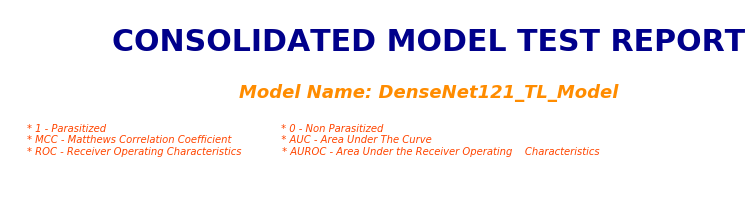

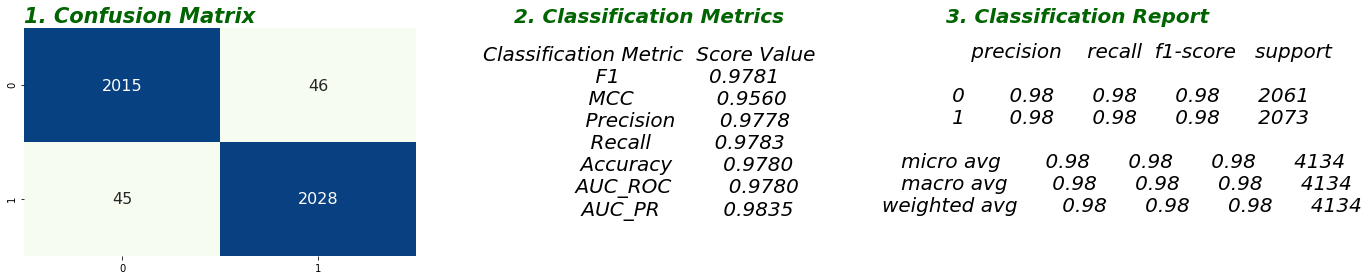

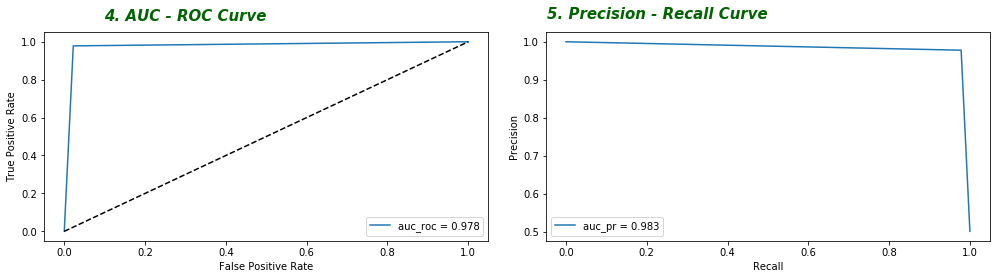

In [17]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "DenseNet121_TL_Model")

<a name='4.2'></a>
### 4.2 Validation Accuracy & Loss - All Models

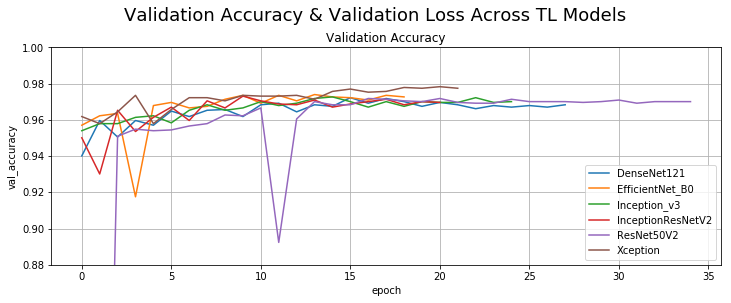

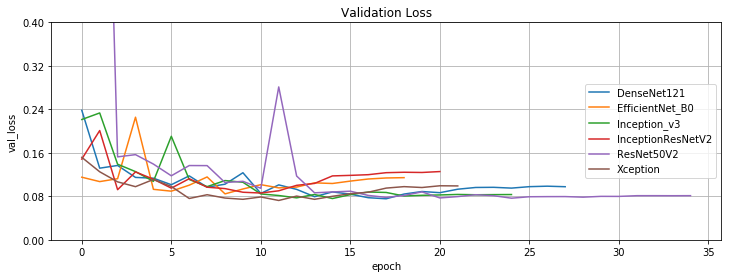

In [57]:
hist1 = pd.read_csv('./Training History/Transfer_Learning_DenseNet121_Train_History.csv')
hist2 = pd.read_csv('./Training History/Transfer_Learning_EfficientNet_B0_Train_History.csv')
hist4 = pd.read_csv('./Training History/Transfer_Learning_Inception_v3_Train_History.csv')
hist5 = pd.read_csv('./Training History/Transfer_Learning_InceptionResNetV2_Train_History.csv')
hist6 = pd.read_csv('./Training History/Transfer_Learning_ResNet50V2_Train_History.csv')
hist7 = pd.read_csv('./Training History/Transfer_Learning_Xception_Train_History.csv')

plt.figure(figsize=(12, 4))
plt.suptitle('Validation Accuracy & Validation Loss Across TL Models', size=18, y=1.02)

plt.plot(hist1['val_accuracy'])
plt.plot(hist2['val_accuracy'])
plt.plot(hist4['val_accuracy'])
plt.plot(hist5['val_accuracy'])
plt.plot(hist6['val_accuracy'])
plt.plot(hist7['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.ylim(0.88, 1)
y_ticks = np.arange(0.88, 1.01, 0.02)
plt.yticks(y_ticks)
plt.grid(True)
plt.legend(['DenseNet121', 'EfficientNet_B0', 'Inception_v3', 'InceptionResNetV2', 
            'ResNet50V2', 'Xception'], loc='lower right')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(hist1['val_loss'])
plt.plot(hist2['val_loss'])
plt.plot(hist4['val_loss'])
plt.plot(hist5['val_loss'])
plt.plot(hist6['val_loss'])
plt.plot(hist7['val_loss'])
plt.title('Validation Loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')

plt.ylim(0, 0.4)
y_ticks = np.arange(0, 0.41, 0.08)
plt.yticks(y_ticks)
plt.grid(True)

plt.legend(['DenseNet121', 'EfficientNet_B0', 'Inception_v3', 'InceptionResNetV2', 
            'ResNet50V2', 'Xception'], loc='center right')

plt.show()

<a name='4.3'></a>
### 4.3 Test Evaluation Metrics for TL Models

In [8]:
metrics=['F1 - Score', 'Accuracy', 'Precision', 'Recall', 'MCC']

dense = [0.9781, 0.9780, 0.9778, 0.9783, 0.9560]
effb0 = [0.9795, 0.9794, 0.9779, 0.9812, 0.9589]
incep = [0.9783, 0.9782, 0.9797, 0.9768, 0.9565]
incep_resv2 = [0.9776, 0.9775, 0.9783, 0.9768, 0.9550]
resnet50 = [0.9778, 0.9777, 0.9792, 0.9764, 0.9555]
Xcep = [0.9771, 0.9770, 0.9769, 0.9773, 0.9540]

fig = go.Figure(data=[
    go.Bar(name='DenseNet121', x=metrics, y=dense, text=dense, textposition='auto'),
    go.Bar(name='EfficientNet-B0', x=metrics, y=effb0, text=effb0, textposition='auto'),
    go.Bar(name='Inception-V3', x=metrics, y=incep, text=incep, textposition='auto'),
    go.Bar(name='InceptionResNet-V2', x=metrics, y=incep_resv2, text=incep_resv2, textposition='auto'),
    go.Bar(name='ResNet50-V2-B0', x=metrics, y=resnet50, text=resnet50, textposition='auto'),
    go.Bar(name='Xception', x=metrics, y=Xcep, text=Xcep, textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Metric Values', range=[0.95, 0.99], dtick=0.007, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Transfer Learning Architectures vs. Classification Metrics...")
fig.show()

### TL Model Test Time Loss

In [9]:
from tensorflow.keras.models import load_model
import glob

for model_path in glob.glob('Training History/TL_Models/*.h5'):
    model = None
    model = load_model(model_path)
    print(model.name + " Test Loss:", model.evaluate(X_test, y_test)[0])

130/130 [==============================] - 9s 71ms/step - loss: 0.0675 - accuracy: 0.9775
Transfer_Learning_Inception_v3 Test Loss: 0.06751162558794022
130/130 [==============================] - 18s 141ms/step - loss: 0.0676 - accuracy: 0.9751
Transfer_Learning_Xception Test Loss: 0.06762287020683289
130/130 [==============================] - 13s 99ms/step - loss: 0.0582 - accuracy: 0.9782
Transfer_Learning_DenseNet121 Test Loss: 0.058237556368112564
130/130 [==============================] - 13s 103ms/step - loss: 0.0655 - accuracy: 0.9770
Transfer_Learning_ResNet50V2 Test Loss: 0.06549201160669327
130/130 [==============================] - 20s 156ms/step - loss: 0.0676 - accuracy: 0.9751
Transfer_Learning_InceptionResNetV2_Retrain_Conv_Base Test Loss: 0.06759048253297806
130/130 [==============================] - 7s 57ms/step - loss: 0.0683 - accuracy: 0.9777
Transfer_Learning_EfficientNet_B0 Test Loss: 0.06825026869773865


<a name='4.4'></a>
### 4.4 AUC ROC & AUC PR Curves - All Models

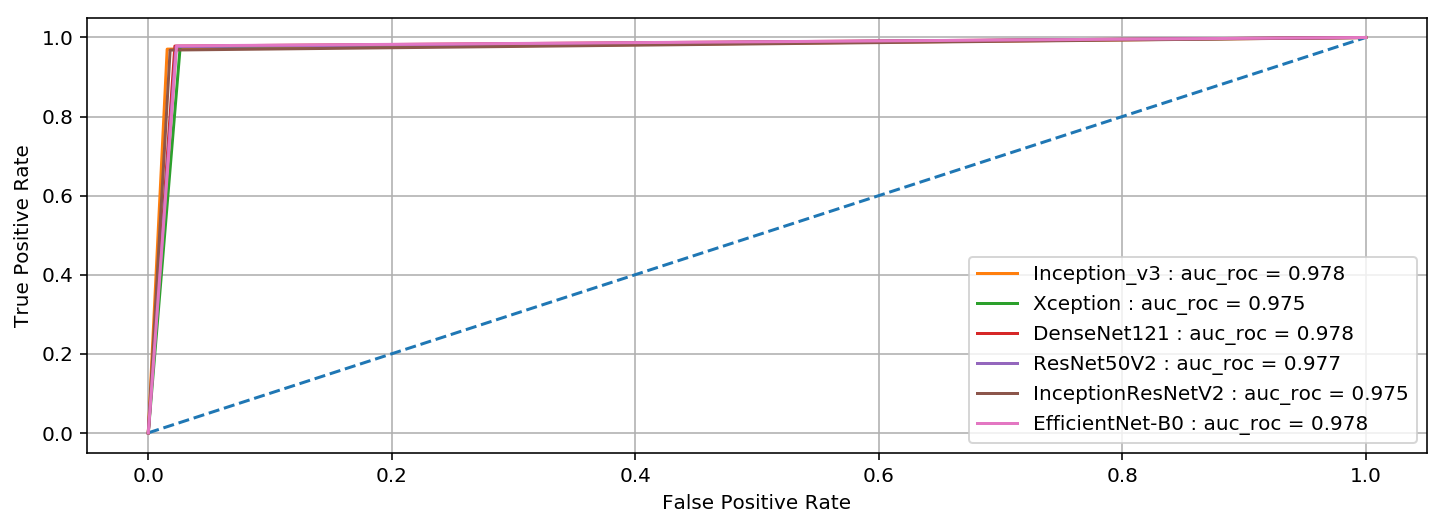

In [10]:
import glob
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc
from tensorflow.keras.models import load_model

plt.figure(figsize=(12, 4))

# plot the base line
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--')

for model_path in glob.glob('Training History/TL_Models/*.h5'):
    model = load_model(model_path)
    if model.name == 'Transfer_Learning_Inception_v3':
        model._name = 'Inception_v3'
    elif model.name == 'Transfer_Learning_Xception':
        model._name = 'Xception'
    elif model.name == 'Transfer_Learning_DenseNet121':
        model._name = 'DenseNet121'
    elif model.name == 'Transfer_Learning_ResNet50V2':
        model._name = 'ResNet50V2'
    elif model.name == 'Transfer_Learning_InceptionResNetV2_Retrain_Conv_Base':
        model._name = 'InceptionResNetV2'
    elif model.name == 'Transfer_Learning_EfficientNet_B0':
        model._name = 'EfficientNet-B0'
        
        
    y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(model, X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_preds_binary)
    model_auc_roc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model.name + " : " + f"auc_roc = {model_auc_roc:.3f}")
    del model

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

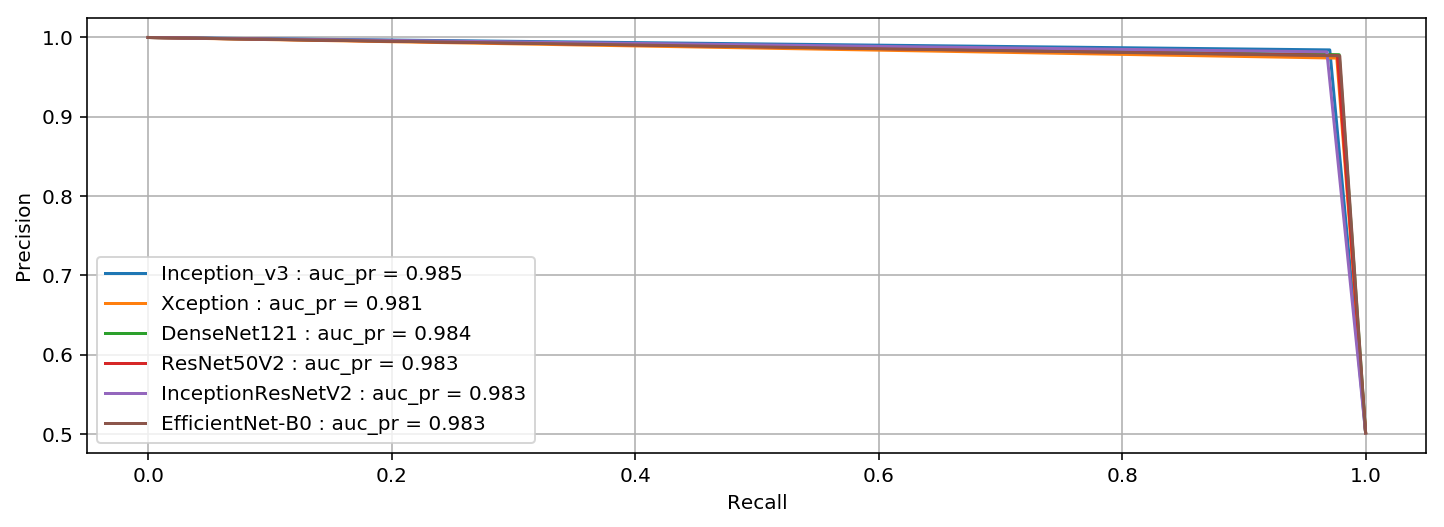

In [21]:
import glob
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from tensorflow.keras.models import load_model

plt.figure(figsize=(12, 4))
for model_path in glob.glob('Training History/TL_Models/*.h5'):
    model = load_model(model_path)
    if model.name == 'Transfer_Learning_Inception_v3':
        model._name = 'Inception_v3'
    elif model.name == 'Transfer_Learning_Xception':
        model._name = 'Xception'
    elif model.name == 'Transfer_Learning_DenseNet121':
        model._name = 'DenseNet121'
    elif model.name == 'Transfer_Learning_ResNet50V2':
        model._name = 'ResNet50V2'
    elif model.name == 'Transfer_Learning_InceptionResNetV2_Retrain_Conv_Base':
        model._name = 'InceptionResNetV2'
    elif model.name == 'Transfer_Learning_EfficientNet_B0':
        model._name = 'EfficientNet-B0'
        
        
    y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(model, X_test)
    precision, recall, th = precision_recall_curve(y_test, y_preds_binary)
    model_auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label=model.name + " : " + f"auc_pr = {model_auc_pr:.3f}")
    del model

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc = "lower left")
plt.grid(True)
plt.show()

<a name='6.5'></a>
## 5. Summary

Transfer learning significantly increases the classification performance. EfficientNet-B0 achieved the highest F1 score of 97.95% followed by the DenseNet121 architecture that got the F1 score of 97.81%. EfficientNet-B0 also achieves the highest recall value of 98.12 amongst the six models. These models also have the least number of false negatives reported as compared to the previous models with 39 and 45 respectively. 

- EfficientNet-B0 outperforms every other transfer learning model.
- EfficientNet-B0 reports the least number of flase predictions.